# Beetaloo: Results (max_iter=10)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Data Pre-processing

In [2]:
# beetaloo dataset
beetaloo = pd.read_csv(filepath_or_buffer='dataset_beetaloo.csv', low_memory=False)
beetaloo.head()

WELL_ID    YEAR  LATITUDE   LONGITUDE  DEPTH  DENSITY       GR  SONIC  \
0  Alexander_1  1988.0 -15.16911  134.855921   63.1      NaN  111.753    NaN   
1  Alexander_1  1988.0 -15.16911  134.855921   63.2      NaN  108.300    NaN   
2  Alexander_1  1988.0 -15.16911  134.855921   63.3      NaN  105.699    NaN   
3  Alexander_1  1988.0 -15.16911  134.855921   63.4      NaN  106.119    NaN   
4  Alexander_1  1988.0 -15.16911  134.855921   63.5      NaN  106.734    NaN   

   RESISTIVITY  SP  NEUTRON  CALIPER  BITSIZE  TOC_CORE  TOC_CUTTINGS  \
0          NaN NaN      NaN    4.705      NaN       NaN           NaN   
1          NaN NaN      NaN    4.701      NaN       NaN           NaN   
2          NaN NaN      NaN    4.676      NaN       NaN           NaN   
3          NaN NaN      NaN    4.668      NaN       NaN           NaN   
4          NaN NaN      NaN    4.691      NaN       NaN           NaN   

                LITHO ORDER_3  ORDER_4  
0  Velkerri Formation   HST-2  RST-2.5  
1  Velkerri Formation   HST-2  RST-2.5  
2  Velkerri Formation   HST-2  RST-2.5  
3  Velkerri Formation   HST-2  RST-2.5  
4  Velkerri Formation   HST-2  RST-2.5

In [3]:
# complete the location of some wells
wells_no_location = ['Balmain_1', 'Birdum_Creek_1', 'Broadmere_1', 'Jamison_1', 'Lady_Penrhyn_1', 'Marmbulligan_1', 'Ronald_1', 'Scarborough_1', 'Sever_1', 'Tarlee_1', 'Walton_2', 'Wyworrie_1']

x_coord = [-92402.40724, 142017.0021, -24907.23409, -501.9841485, 82970.28312, 17486.61935, 86665.76837, -125242.803, -124956.7945, -38322.74503, -135702.1635]
y_coord = [-1809383.515, -1887528.408, -1936401.136, -1747313.691, -1872700.38, -1877801.953, -1759280.809, -1766817.469, -1845740.884, -1839970.706, -1780656.283]

lat = [-16.620444] 
lon = [133.577361]

# convert GDA94 to WGS84
import pyproj
# GDA94 / Geoscience Australia Lambert, EPSG:3112
# WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS, EPSG:4326
gda94_wgs84 = pyproj.Transformer.from_crs(3112, 4326)
for i in range(len(x_coord)):
    new_coord = gda94_wgs84.transform(x_coord[i], y_coord[i])
    lat.append(new_coord[0])
    lon.append(new_coord[1])

# replace coordinates in the dataset
for i in range(len(wells_no_location)):
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LATITUDE'] = lat[i]
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LONGITUDE'] = lon[i]
    
# rename columns
beetaloo.rename(columns={'LONGITUDE': 'X',
                         'LATITUDE' : 'Y',
                         'DENSITY': 'RHOB', 
                         'SONIC': 'DT',
                         'RESISTIVITY': 'RES', 
                         'NEUTRON': 'NPHI',
                         'ORDER_4': 'STRAT'
                        }, inplace=True
               )

# drop unnecessary columns
beetaloo.drop(['YEAR', 'CALIPER', 'BITSIZE', 'TOC_CORE', 'TOC_CUTTINGS', 'ORDER_3'], axis=1, inplace=True)

# handle outliers and well-log transformation

# replace sonic values smaller than 0 for NaN values
mask = beetaloo['DT'] < 0
beetaloo.loc[mask, 'DT'] = np.nan

# replace resistivity values smaller than or equal to 0 for NaN values
mask = beetaloo['RES'] <= 0
beetaloo.loc[mask, 'RES'] = np.nan

# create a new column to store log base 10 of resistivity
beetaloo['RES_10'] = np.log10(beetaloo['RES']+1)

# replace neutron porosity values smaller than 0 for NaN values
mask = beetaloo['NPHI'] < 0
beetaloo.loc[mask, 'NPHI'] = np.nan

# convert percentage to fraction
def convert_neutron(x):
    if x >= 1:
        return x / 100
    else:
        return x

beetaloo['NPHI'] = beetaloo['NPHI'].apply(convert_neutron)

In [4]:
# label encoding for well id
well_encoder = LabelEncoder()
beetaloo['WELL'] = well_encoder.fit_transform(beetaloo['WELL_ID'])

# feature selection
selected_features = ['WELL', 'X', 'Y', 'DEPTH', 
                     'RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI',
                     'LITHO', 'STRAT']

## 2. Data Splitting

In [5]:
# copy of the dataset for modeling
data_ml = beetaloo[selected_features].copy()

In [6]:
# well test selection
test_wells = well_encoder.transform(['Tarlee_2', 'Beetaloo_W1', 'Friendship_1', 'Burdo_1', 'McManus_1', 'Amungee_NW1'])

# mask for test well
test_mask = data_ml['WELL'].isin(test_wells)

# column to identify train and test wells
data_ml['train_test'] = 'Train'
data_ml.loc[test_mask, 'train_test'] = 'Test'

# fraction of data
train_fraction = data_ml[data_ml['train_test'] == 'Train'].shape[0] / data_ml.shape[0]
test_fraction = data_ml[data_ml['train_test'] == 'Test'].shape[0] / data_ml.shape[0]
print(f"Fraction of data in train set: {train_fraction:.2f}")
print(f"Fraction of data in test set: {test_fraction:.2f}")
print(f"Total number of samples in dataset: {data_ml.shape[0]}")

Fraction of data in train set: 0.83
Fraction of data in test set: 0.17
Total number of samples in dataset: 352143


In [7]:
# create train and test sets
train = data_ml[~test_mask].copy()
test = data_ml[test_mask].copy()

## 3. Results

In [8]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

### Training: Cross-Validation

In [9]:
# knr
with open('train_results_knr.txt', 'r') as f:
    train_results_knr = json.load(f)

# br
with open('train_results_br.txt', 'r') as f:
    train_results_br = json.load(f)

# rf
with open('train_results_rf.txt', 'r') as f:
    train_results_rf = json.load(f)
    
# xgb
with open('train_results_xgb.txt', 'r') as f:
    train_results_xgb = json.load(f)


In [10]:
def compare_well_logs(results, well_logs):
    metrics = list(results.keys())  
    data = []
    
    for i, metric in enumerate(metrics):
        average_values = [np.mean(results[metric][log]) for log in well_logs]
        data.append(average_values)
    
    df = pd.DataFrame(data, index=metrics, columns=well_logs)
    display(df)
    return df

train_knr = compare_well_logs(results=train_results_knr, well_logs=well_logs)
train_br = compare_well_logs(results=train_results_br, well_logs=well_logs)
train_rf = compare_well_logs(results=train_results_rf, well_logs=well_logs)
train_xgb = compare_well_logs(results=train_results_xgb, well_logs=well_logs)


RHOB        GR        DT    RES_10          SP      NPHI
R2  -1.027622 -1.968781 -1.487230 -1.193578 -170.747631 -5.114195
MAE  0.026651  0.116297  0.079770  0.081415    0.166816  0.053014
MSE  0.002167  0.023746  0.011608  0.014559    0.059218  0.010843

RHOB        GR        DT    RES_10          SP       NPHI
R2  -12.047774 -8.724554 -8.240515 -2.048697 -521.556920 -13.023136
MAE   0.047884  0.144401  0.113650  0.097747    0.189704   0.052987
MSE   0.005086  0.036043  0.019999  0.020877    0.058477   0.005248

RHOB        GR        DT    RES_10          SP      NPHI
R2  -0.766202 -1.790313 -9.828551 -0.431841 -232.561348 -0.801576
MAE  0.026646  0.111021  0.087323  0.068415    0.160239  0.041410
MSE  0.002291  0.022135  0.014014  0.010568    0.053338  0.003139

RHOB        GR        DT    RES_10          SP      NPHI
R2  -0.484482 -2.098557 -1.618170 -0.506781 -193.494786 -4.607093
MAE  0.024355  0.102978  0.074425  0.069374    0.164758  0.041372
MSE  0.001677  0.019694  0.010157  0.013023    0.055805  0.003022

In [11]:
train_results = {'KNR': train_knr,
                 'BR': train_br,
                 'RF': train_rf,
                 'XGB': train_xgb
                }

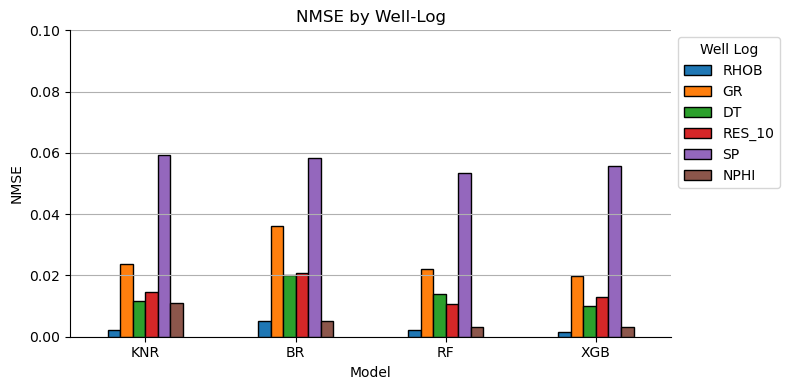

In [12]:
# NMSE - normalized mean squared error

metric = 'MSE'

model_data = []

for model_name, model_df in train_results.items():
    metric_values = model_df.loc[metric]
    model_data.append(metric_values)

df = pd.DataFrame(model_data, index=train_results.keys(), columns=well_logs)

ax = df.plot(kind='bar', figsize=(8, 4), edgecolor='black')

plt.title(f'N{metric} by Well-Log')
plt.xlabel('Model')
plt.ylabel('NMSE')

plt.xticks(rotation='horizontal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

ax.set_ylim([0, 0.1])

plt.tight_layout() 
plt.show()


# NMAE - normalized absolute error

metric = 'MAE'

model_data = []

for model_name, model_df in train_results.items():
    metric_values = model_df.loc[metric]
    model_data.append(metric_values)

df = pd.DataFrame(model_data, index=train_results.keys(), columns=well_logs)

ax = df.plot(kind='bar', figsize=(8, 4), edgecolor='black')

plt.title(f'N{metric} by Well-Log')
plt.xlabel('Model')
plt.ylabel('NMAE')

plt.xticks(rotation='horizontal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

# ax.set_ylim([-1, 1])

plt.tight_layout() 
plt.show()



# R2

metric = 'R2'

model_data = []

for model_name, model_df in train_results.items():
    metric_values = model_df.loc[metric]
    model_data.append(metric_values)

df = pd.DataFrame(model_data, index=train_results.keys(), columns=well_logs)

ax = df.plot(kind='bar', figsize=(8, 4), edgecolor='black')

plt.title(f'{metric} by Well-Log')
plt.xlabel('Model')
plt.ylabel(metric)

plt.xticks(rotation='horizontal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

ax.set_ylim([-1, 1])

plt.tight_layout() 
plt.show()

In [13]:
# time in seconds of cross-validation
train_time = {'KNR': 12468.07,
              'BR': 4607.77 ,
              'RF': 14131.66,
              'XGB': 11027.36
             }

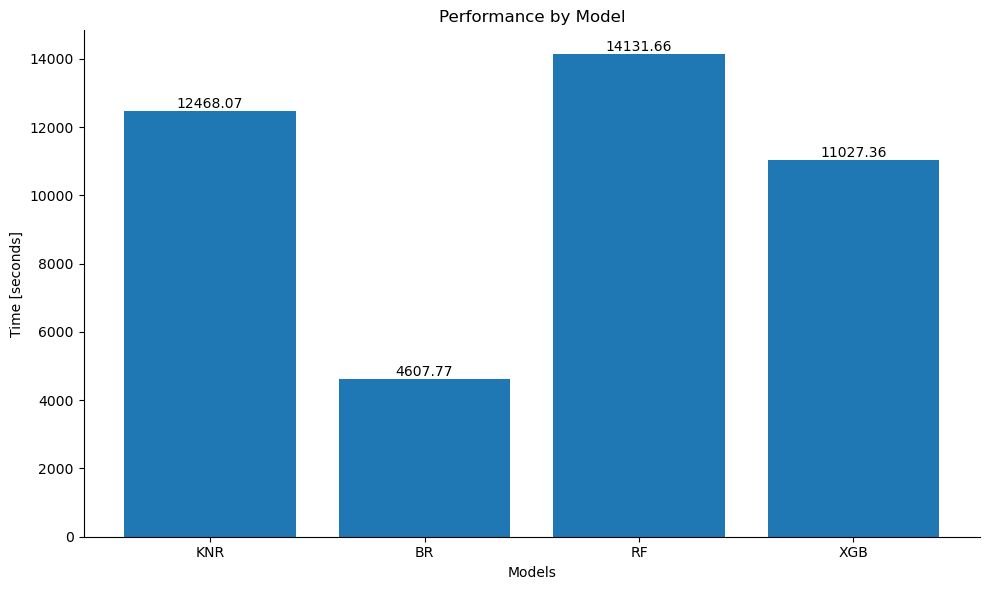

In [14]:
time_df = pd.DataFrame.from_dict(train_time, orient='index', columns=['Time'])

fig, axes = plt.subplots(figsize=(10, 6))

axes.bar(time_df.index, time_df['Time'])
axes.set_ylabel('Time [seconds]')
axes.set_xlabel('Models')
axes.set_title('Performance by Model')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
for value in axes.containers:
    axes.bar_label(value, fmt='%.2f', label_type='edge')
plt.grid(False)
plt.tight_layout()
plt.show()


### Test

In [15]:
# results from mice
test_result_knr = pd.read_csv('test_result_knr.csv').add_suffix('_KNR')
test_result_br = pd.read_csv('test_result_br.csv').add_suffix('_BR')
test_result_rf = pd.read_csv('test_result_rf.csv').add_suffix('_RF')
test_result_xgb = pd.read_csv('test_result_xgb.csv').add_suffix('_XGB')

In [16]:
test_df = test.copy()
test_df.reset_index(drop=True, inplace=True)

# merge mice results with the test data
test_df = test_df.merge(test_result_knr, left_index=True, right_index=True)
test_df = test_df.merge(test_result_br, left_index=True, right_index=True)
test_df = test_df.merge(test_result_rf, left_index=True, right_index=True)
test_df = test_df.merge(test_result_xgb, left_index=True, right_index=True)


In [17]:
test_df

WELL           X          Y     DEPTH  RHOB  GR  DT  RES_10  SP  NPHI  \
0         2  133.884556 -16.347509  1192.500   NaN NaN NaN     NaN NaN   NaN   
1         2  133.884556 -16.347509  1237.500   NaN NaN NaN     NaN NaN   NaN   
2         2  133.884556 -16.347509  1272.500   NaN NaN NaN     NaN NaN   NaN   
3         2  133.884556 -16.347509  1312.500   NaN NaN NaN     NaN NaN   NaN   
4         2  133.884556 -16.347509  1352.500   NaN NaN NaN     NaN NaN   NaN   
...     ...         ...        ...       ...   ...  ..  ..     ...  ..   ...   
60732    28  132.683458 -15.890177  1181.862   NaN NaN NaN     NaN NaN   NaN   
60733    28  132.683458 -15.890177  1182.014   NaN NaN NaN     NaN NaN   NaN   
60734    28  132.683458 -15.890177  1182.167   NaN NaN NaN     NaN NaN   NaN   
60735    28  132.683458 -15.890177  1182.319   NaN NaN NaN     NaN NaN   NaN   
60736    28  132.683458 -15.890177  1182.472   NaN NaN NaN     NaN NaN   NaN   

       ... DT_IMP_SCALED_XGB RES_10_IMP_SCALED_XGB SP_IMP_SCALED_XGB  \
0      ...          0.383057              0.287942          0.335910   
1      ...          0.415621              0.269179          0.685202   
2      ...          0.415621              0.269179          0.685202   
3      ...          0.415621              0.269179          0.685202   
4      ...          0.318792              0.352109          0.675427   
...    ...               ...                   ...               ...   
60732  ...          0.517812              0.202861               NaN   
60733  ...          0.517812              0.202861               NaN   
60734  ...          0.517812              0.202861               NaN   
60735  ...          0.517812              0.202861               NaN   
60736  ...          0.517812              0.202861               NaN   

       NPHI_IMP_SCALED_XGB  RHOB_IMP_XGB  GR_IMP_XGB  DT_IMP_XGB  \
0                 0.158203      2.610820  170.500605   74.189763   
1                 0.279445      2.625893  173.055377   77.940339   
2                 0.279445      2.625893  173.055377   77.940339   
3                 0.279445      2.625893  173.055377   77.940339   
4                 0.188757      2.683234  181.480413   66.787830   
...                    ...           ...         ...         ...   
60732             0.207235      2.631681  137.433518   89.710518   
60733             0.207235      2.631681  137.433518   89.710518   
60734             0.207235      2.631681  137.433518   89.710518   
60735             0.207235      2.631681  137.433518   89.710518   
60736             0.207235      2.631681  137.433518   89.710518   

       RES_10_IMP_XGB  SP_IMP_XGB  NPHI_IMP_XGB  
0            1.440020 -112.645681      0.157571  
1            1.346215   65.274861      0.278327  
2            1.346215   65.274861      0.278327  
3            1.346215   65.274861      0.278327  
4            1.760829   60.295456      0.188002  
...               ...         ...           ...  
60732        1.014652         NaN      0.206406  
60733        1.014652         NaN      0.206406  
60734        1.014652         NaN      0.206406  
60735        1.014652         NaN      0.206406  
60736        1.014652         NaN      0.206406  

[60737 rows x 85 columns]

### 3.1. MICE Performance

In [18]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
models = ['KNR', 'BR', 'RF', 'XGB']

evaluation_results = {}
for log in well_logs:
    
    evaluation_results[log] = {}
    for model in models:

        column_name = f'{log}_{model}'
        
        original_values = test_df[f'{log}_SCALED_{model}'].dropna()
        original_index = list(original_values.index.values)
        imputed_values = test_df.loc[original_index, f'{log}_IMP_SCALED_{model}']
        
        mae = mean_absolute_error(original_values, imputed_values)
        mse = mean_squared_error(original_values, imputed_values)
        r2 = r2_score(original_values, imputed_values)
        
        evaluation_results[log][model] = {'R2': r2, 'NMAE': mae, 'NMSE': mse}

evaluation_results_df = {}
for log, models in evaluation_results.items():
    
    table_data = []
    for model, metrics in models.items():
        cols = {'Model': model, 'R2': metrics['R2'], 'NMAE': metrics['NMAE'], 'NMSE': metrics['NMSE']}
        table_data.append(cols)
    
    df = pd.DataFrame(table_data)
    
    evaluation_results_df[log] = df

for log, df in evaluation_results_df.items():
    print(f'Well-log: {log}')
    display(df.round(4).sort_values('NMSE', ascending=True))
    print('\n')

Well-log: RHOB


Model      R2    NMAE    NMSE
3   XGB  0.1692  0.0145  0.0005
0   KNR -0.2978  0.0177  0.0008
2    RF -0.4834  0.0166  0.0009
1    BR -1.7185  0.0316  0.0017



Well-log: GR


Model      R2    NMAE    NMSE
0   KNR  0.2388  0.1038  0.0207
2    RF  0.0574  0.1261  0.0257
3   XGB  0.0236  0.1274  0.0266
1    BR -0.1985  0.1473  0.0326



Well-log: DT


Model      R2    NMAE    NMSE
1    BR  0.5831  0.0364  0.0027
3   XGB  0.3802  0.0478  0.0041
2    RF  0.3109  0.0518  0.0045
0   KNR -0.0161  0.0594  0.0067



Well-log: RES_10


Model      R2    NMAE    NMSE
2    RF  0.1997  0.0517  0.0046
3   XGB  0.1986  0.0506  0.0046
1    BR  0.0674  0.0566  0.0054
0   KNR -0.1587  0.0550  0.0067



Well-log: SP


Model       R2    NMAE    NMSE
0   KNR -12.9527  0.1908  0.0601
3   XGB -15.1093  0.2307  0.0693
2    RF -15.5673  0.2298  0.0713
1    BR -20.8228  0.2830  0.0939



Well-log: NPHI


Model      R2    NMAE    NMSE
0   KNR  0.2442  0.0417  0.0029
1    BR -0.0030  0.0507  0.0038
3   XGB -0.0620  0.0528  0.0040
2    RF -0.3289  0.0577  0.0050

In [19]:
r2_results_df = pd.DataFrame()
mae_results_df = pd.DataFrame()
mse_results_df = pd.DataFrame()

for log, df in evaluation_results_df.items():
    r2_results_df[log] = df['R2']
    mae_results_df[log] = df['NMAE']
    mse_results_df[log] = df['NMSE']

r2_results_df.index = df['Model']
mae_results_df.index = df['Model']
mse_results_df.index = df['Model']
    

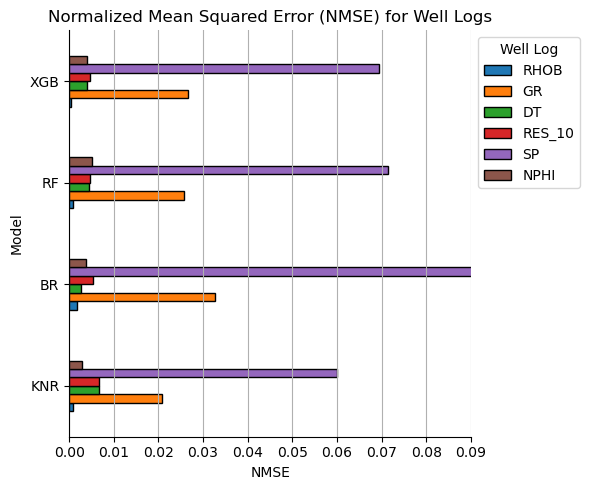

Model      KNR      BR      RF     XGB
RHOB    0.0008  0.0017  0.0009  0.0005
GR      0.0207  0.0326  0.0257  0.0266
DT      0.0067  0.0027  0.0045  0.0041
RES_10  0.0067  0.0054  0.0046  0.0046
SP      0.0601  0.0939  0.0713  0.0693
NPHI    0.0029  0.0038  0.0050  0.0040

In [20]:
ax = mse_results_df.plot(kind='barh', figsize=(6, 5), edgecolor='black')

plt.title('Normalized Mean Squared Error (NMSE) for Well Logs')
plt.ylabel('Model')
plt.xlabel('NMSE')

plt.xticks(rotation='horizontal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

ax.set_xlim([0, 0.09])

plt.tight_layout() 
plt.show()

display(mse_results_df.T.round(4))


In [21]:
ax = mae_results_df.plot(kind='bar', figsize=(8, 4), edgecolor='black')

plt.title('Normalized Mean Absolute Error (NMAE) for Well Logs')
plt.xlabel('Model')
plt.ylabel('MAE')

plt.xticks(rotation='horizontal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True)
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))

plt.tight_layout() 
plt.show()

# ax.set_ylim([0, 0.1])

display(mae_results_df.T.round(4))


Model      KNR      BR      RF     XGB
RHOB    0.0177  0.0316  0.0166  0.0145
GR      0.1038  0.1473  0.1261  0.1274
DT      0.0594  0.0364  0.0518  0.0478
RES_10  0.0550  0.0566  0.0517  0.0506
SP      0.1908  0.2830  0.2298  0.2307
NPHI    0.0417  0.0507  0.0577  0.0528

In [22]:
ax = r2_results_df.plot(kind='barh', figsize=(6, 5), edgecolor='black')

plt.title('R2 Score for Well Logs')
plt.ylabel('Model')
plt.xlabel('R2 Score')
ax.legend(title='Well Log', bbox_to_anchor=(1, 1))
plt.xticks(rotation='horizontal')
plt.axvline(0, color='black', linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.grid(True)

ax.set_xlim([-1, 1])

plt.tight_layout()  
plt.show()
display(r2_results_df.T.round(2))


Model     KNR     BR     RF    XGB
RHOB    -0.30  -1.72  -0.48   0.17
GR       0.24  -0.20   0.06   0.02
DT      -0.02   0.58   0.31   0.38
RES_10  -0.16   0.07   0.20   0.20
SP     -12.95 -20.82 -15.57 -15.11
NPHI     0.24  -0.00  -0.33  -0.06

### 3.2. Performance by Well

In [23]:
# non-missing values for each columns
missing_wells = pd.DataFrame({'Non-Missing': test.count()/test.shape[0]})

# missing values for each well
for well, df in test.groupby('WELL'):
    missing_wells[well] = 1 - (df.count() / df.shape[0])
    
missing_wells = missing_wells.T


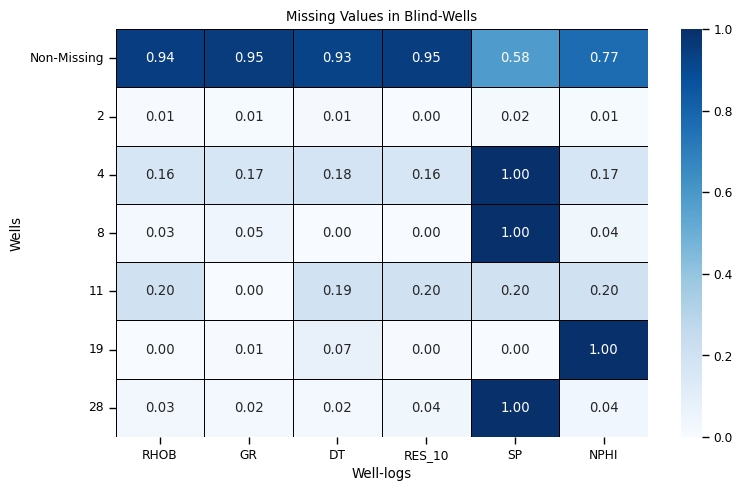

In [24]:
# fraction of missing values for each well
fig = plt.figure(figsize=(8, 5))
sns.set_context('paper')
cmap = sns.color_palette(palette='Blues', as_cmap=True)
axes = sns.heatmap(missing_wells[well_logs], linecolor='black', linewidths=0.5, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2f')
axes.set_xlabel('Well-logs')
axes.set_ylabel('Wells')
axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
plt.title('Missing Values in Blind-Wells')
plt.tight_layout()

In [25]:
unique_wells = test_df['WELL'].unique()

well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
models = ['KNR', 'BR', 'RF', 'XGB']

# NMSE and R2
for well in unique_wells:
    well_data = test_df.loc[test_df['WELL'] == well]
    
    print('Blind-Well:', well)
    
    evaluation_results = {}
    for log in well_logs:

        evaluation_results[log] = {}
        for model in models:

            column_name = f'{log}_{model}'
            
            original_values = well_data[f'{log}_SCALED_{model}'].dropna()
            original_index = list(original_values.index.values)
            imputed_values = well_data.loc[original_index, f'{log}_IMP_SCALED_{model}']

            
            if original_values.notnull().any():
            
                mae = mean_absolute_error(original_values, imputed_values)
                mse = mean_squared_error(original_values, imputed_values)
                r2 = r2_score(original_values, imputed_values)
            else:
                mae, mse, r2 = None, None, None

            evaluation_results[log][model] = {'R2': r2, 'NMAE': mae, 'NMSE': mse}

    evaluation_results_df = {}
    for log, models in evaluation_results.items():

        table_data = []
        for model, metrics in models.items():
            cols = {'Model': model, 'R2': metrics['R2'], 'NMAE': metrics['NMAE'], 'NMSE': metrics['NMSE']}
            table_data.append(cols)

        df = pd.DataFrame(table_data)

        evaluation_results_df[log] = df


    r2_results_df = pd.DataFrame()
    mae_results_df = pd.DataFrame()
    mse_results_df = pd.DataFrame()

    for log, df in evaluation_results_df.items():
        r2_results_df[log] = df['R2']
        mae_results_df[log] = df['NMAE']
        mse_results_df[log] = df['NMSE']

    r2_results_df.index = df['Model']
    mae_results_df.index = df['Model']
    mse_results_df.index = df['Model']
    
    # results
    print('NMSE')
    display(mse_results_df.T.mean())
    print('R2')
    display(r2_results_df.T.mean())
    
    print('\n')

Blind-Well: 2
NMSE


Model
KNR    0.020088
BR     0.029248
RF     0.026238
XGB    0.025155
dtype: float64

R2


Model
KNR    -91.575502
BR    -134.462512
RF    -110.586347
XGB   -105.562039
dtype: float64



Blind-Well: 4
NMSE


Model
KNR    0.005548
BR     0.003626
RF     0.003362
XGB    0.002966
dtype: float64

R2


Model
KNR    0.006260
BR     0.375715
RF     0.423807
XGB    0.483108
dtype: float64



Blind-Well: 8
NMSE


Model
KNR    0.003931
BR     0.003019
RF     0.002664
XGB    0.003249
dtype: float64

R2


Model
KNR   -0.280714
BR    -0.777694
RF     0.232401
XGB    0.132419
dtype: float64



Blind-Well: 11
NMSE


Model
KNR    0.005038
BR     0.011649
RF     0.005343
XGB    0.006112
dtype: float64

R2


Model
KNR    -12.853885
BR    -240.952819
RF     -23.368912
XGB    -47.054668
dtype: float64



Blind-Well: 19
NMSE


Model
KNR    0.017606
BR     0.026339
RF     0.015264
XGB    0.016333
dtype: float64

R2


Model
KNR   -21.565678
BR    -48.902426
RF    -21.967645
XGB   -24.296435
dtype: float64



Blind-Well: 28
NMSE


Model
KNR    0.004246
BR     0.004672
RF     0.003819
XGB    0.002809
dtype: float64

R2


Model
KNR   -0.340310
BR    -0.372875
RF    -0.041317
XGB    0.106051
dtype: float64

In [26]:
test['WELL'] = test['WELL'].astype(str)

well_counts = test.groupby('WELL').count()
well_counts['Total'] = test.groupby('WELL').size()

well_counts_sorted = well_counts.sort_values(by='Total')
well_counts_sorted['Total']

WELL
11     2623
8      4863
28     4979
19    10711
4     14549
2     23012
Name: Total, dtype: int64

In [27]:
test['WELL'].unique().tolist()

['2', '4', '8', '11', '19', '28']

In [28]:
wells = ['2', '4', '8', '11', '19', '28']

avg_nmse = [0.02518225, 0.0038755, 0.00321575, 
            0.0070355, 0.0188855, 0.0038865]
avg_r2 = [-110.5466, 0.3222225, -0.173397, 
          -81.057571, -29.183046, -0.16211275]

data_wells = {'WELLS': wells,
              'AVG_NMSE': avg_nmse,
              'AVG_R2': avg_r2
             }

df_wells = pd.DataFrame(data_wells)

df_wells = df_wells.merge(well_counts_sorted[['Total']], how='left', left_on='WELLS', right_index=True)
df_wells.rename(columns={'Total': 'TOTAL'}, inplace=True)
df_wells.sort_values(by='TOTAL', ascending=False, inplace=True)

df_wells


WELLS  AVG_NMSE      AVG_R2  TOTAL
0     2  0.025182 -110.546600  23012
1     4  0.003876    0.322223  14549
4    19  0.018885  -29.183046  10711
5    28  0.003887   -0.162113   4979
2     8  0.003216   -0.173397   4863
3    11  0.007036  -81.057571   2623

In [29]:
num_wells = len(df_wells)
colors = plt.cm.Blues(np.linspace(0.3, 1, num_wells))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

plt.suptitle('Blind-Well Test Set', fontsize=16, y=1.02)

axes[0].barh(df_wells['WELLS'], df_wells['TOTAL'], color=colors)
axes[0].set_xlabel('Number of Observations')
axes[0].set_ylabel('Wells')
axes[0].set_title('Total of Observations')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
for value in axes[0].containers:
    axes[0].bar_label(value, label_type='edge')
plt.grid(False)


axes[1].barh(df_wells['WELLS'], df_wells['AVG_NMSE'], color=colors)
axes[1].set_xlabel('NMSE')
axes[1].set_title('Average NMSE')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_visible(False)
for value in axes[1].containers:
    axes[1].bar_label(value, fmt='%.4f', label_type='edge')
plt.grid(False)

axes[2].barh(df_wells['WELLS'], df_wells['AVG_R2'], color=colors)
axes[2].set_xlabel('R2')
axes[2].set_title('Average R2')
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].yaxis.set_visible(False)
axes[2].axvline(x=0, color='black')

# axes[2].set_xlim(-1, 1)
for value in axes[2].containers:
    axes[2].bar_label(value, fmt='%.4f', label_type='edge')
plt.grid(False)

plt.tight_layout()
plt.show()


### 3.3. Performance by Stratigraphy

#### Train

In [24]:

missing_strat = pd.DataFrame({'Non-Missing': train.count()/train.shape[0]})


for well, df in train.groupby('STRAT'):
    missing_strat[well] = 1 - (df.count() / df.shape[0])
    
missing_strat = missing_strat.T


In [31]:
# fraction of missing values for each stratigraphy
fig = plt.figure(figsize=(10, 6))
sns.set_context('paper')
cmap = sns.color_palette(palette='Blues', as_cmap=True)
axes = sns.heatmap(missing_strat[well_logs], linecolor='black', linewidths=0.5, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2f')
axes.set_xlabel('Well-logs')
axes.set_ylabel('Stratigraphy')
plt.tight_layout()

In [32]:
# count the number of observations for each stratigraphy
strat_counts = train.groupby('STRAT').count()
strat_counts['Total'] = train.groupby('STRAT').size()

# sort stratigraphy by total number of observations
strat_counts_sorted = strat_counts.sort_values(by='Total')

# plot the results
fig, axes = plt.subplots(figsize=(8,6))
axes.barh(strat_counts_sorted.index, strat_counts_sorted['Total'].values)
axes.set_xlabel('Number of Observations')
axes.set_ylabel('Stratigraphy')
axes.set_title('Total of Observations by Stratigraphy - Training Set')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# add count values to each bar
for value in axes.containers:
    axes.bar_label(value, label_type='edge')
plt.grid(False)
plt.tight_layout()
plt.show()


#### Test

In [33]:
# non-missing values for each columns
missing_strat = pd.DataFrame({'Non-Missing': test.count()/test.shape[0]})

# missing values for each stratigraphy
for well, df in test.groupby('STRAT'):
    missing_strat[well] = 1 - (df.count() / df.shape[0])
    
missing_strat = missing_strat.T

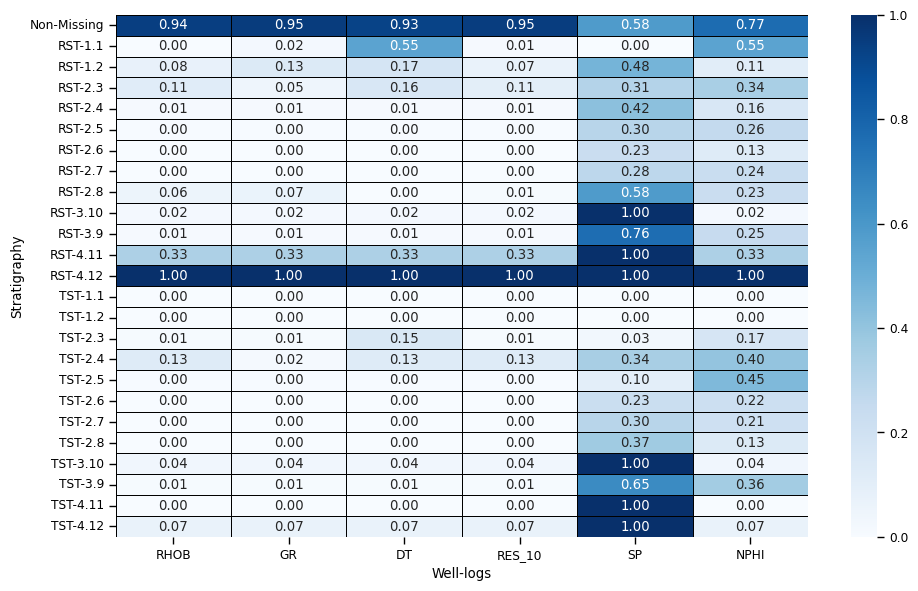

In [34]:
# fraction of missing values for each stratigraphy
fig = plt.figure(figsize=(10, 6))
sns.set_context('paper')
cmap = sns.color_palette(palette='Blues', as_cmap=True)
axes = sns.heatmap(missing_strat[well_logs], linecolor='black', linewidths=0.5, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2f')
axes.set_xlabel('Well-logs')
axes.set_ylabel('Stratigraphy')
plt.tight_layout()

In [35]:
unique_strat = ['RST-2.6', 'RST-2.5', 'RST-2.4', 'RST-2.7', 'RST-2.3',
                'RST-2.8', 'RST-3.9', 'RST-4.11', 'RST-1.2', 'TST-2.4', 
                'TST-4.11', 'RST-1.1', 'TST-3.9', 'TST-2.6', 'RST-3.10',
                'TST-4.12', 'TST-2.5', 'TST-2.3', 'TST-1.1', 'TST-2.7',
                'TST-2.8', 'TST-1.2', 'TST-3.10']

well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
models = ['KNR', 'BR', 'RF', 'XGB']

# NMSE and R2
for strat in unique_strat:
    strat_data = test_df.loc[test_df['STRAT'] == strat]
    
    print('Stratigraphy:', strat)
    
    evaluation_results = {}
    for log in well_logs:

        evaluation_results[log] = {}
        for model in models:

            column_name = f'{log}_{model}'

            original_values = strat_data[f'{log}_SCALED_{model}'].dropna()
            original_index = list(original_values.index.values)
            imputed_values = strat_data.loc[original_index, f'{log}_IMP_SCALED_{model}']

            
            if original_values.notnull().any():
            
                mae = mean_absolute_error(original_values, imputed_values)
                mse = mean_squared_error(original_values, imputed_values)
                r2 = r2_score(original_values, imputed_values)
            else:
                mae, mse, r2 = None, None, None

            evaluation_results[log][model] = {'R2': r2, 'NMAE': mae, 'NMSE': mse}

    evaluation_results_df = {}
    for log, models in evaluation_results.items():

        table_data = []
        for model, metrics in models.items():
            cols = {'Model': model, 'R2': metrics['R2'], 'NMAE': metrics['NMAE'], 'NMSE': metrics['NMSE']}
            table_data.append(cols)

        df = pd.DataFrame(table_data)

        evaluation_results_df[log] = df


    r2_results_df = pd.DataFrame()
    mae_results_df = pd.DataFrame()
    mse_results_df = pd.DataFrame()

    for log, df in evaluation_results_df.items():
        r2_results_df[log] = df['R2']
        mae_results_df[log] = df['NMAE']
        mse_results_df[log] = df['NMSE']

    r2_results_df.index = df['Model']
    mae_results_df.index = df['Model']
    mse_results_df.index = df['Model']
    
    # results
    print('NMSE')
    display(mse_results_df.T.mean())
    print('R2')
    display(r2_results_df.T.mean())
    
    print('\n')
    

Stratigraphy: RST-2.6
NMSE


Model
KNR    0.016772
BR     0.033551
RF     0.023579
XGB    0.021108
dtype: float64

R2


Model
KNR   -4.645473
BR    -9.873701
RF    -6.658374
XGB   -5.682000
dtype: float64



Stratigraphy: RST-2.5
NMSE


Model
KNR    0.017279
BR     0.027624
RF     0.023435
XGB    0.023252
dtype: float64

R2


Model
KNR   -2.665400
BR    -4.364080
RF    -3.491106
XGB   -3.325099
dtype: float64



Stratigraphy: RST-2.4
NMSE


Model
KNR    0.013893
BR     0.014904
RF     0.016738
XGB    0.015869
dtype: float64

R2


Model
KNR   -3.300986
BR    -3.813895
RF    -4.984023
XGB   -4.766148
dtype: float64



Stratigraphy: RST-2.7
NMSE


Model
KNR    0.015941
BR     0.020498
RF     0.014149
XGB    0.012735
dtype: float64

R2


Model
KNR   -2.313059
BR    -3.843393
RF    -2.493551
XGB   -1.807553
dtype: float64



Stratigraphy: RST-2.3
NMSE


Model
KNR    0.027575
BR     0.024005
RF     0.020180
XGB    0.023342
dtype: float64

R2


Model
KNR   -3.833766
BR    -4.057959
RF    -2.422590
XGB   -2.698483
dtype: float64



Stratigraphy: RST-2.8
NMSE


Model
KNR    0.014879
BR     0.018600
RF     0.016834
XGB    0.015966
dtype: float64

R2


Model
KNR   -2.786478
BR    -3.727626
RF    -3.566218
XGB   -2.902159
dtype: float64



Stratigraphy: RST-3.9
NMSE


Model
KNR    0.008699
BR     0.010291
RF     0.004459
XGB    0.004814
dtype: float64

R2


Model
KNR   -185.108130
BR    -270.527961
RF     -44.840500
XGB    -49.693138
dtype: float64



Stratigraphy: RST-4.11
NMSE


Model
KNR    0.002446
BR     0.001752
RF     0.002029
XGB    0.002405
dtype: float64

R2


Model
KNR   -2.149835
BR    -0.953204
RF    -1.614904
XGB   -1.903908
dtype: float64



Stratigraphy: RST-1.2
NMSE


Model
KNR    0.009944
BR     0.014902
RF     0.011758
XGB    0.011998
dtype: float64

R2


Model
KNR   -2.002326
BR    -5.404326
RF    -2.772769
XGB   -2.356103
dtype: float64



Stratigraphy: TST-2.4
NMSE


Model
KNR    0.030147
BR     0.031339
RF     0.029363
XGB    0.031322
dtype: float64

R2


Model
KNR    -6.429940
BR     -9.126353
RF    -11.779862
XGB    -8.007670
dtype: float64



Stratigraphy: TST-4.11
NMSE


Model
KNR    0.003216
BR     0.004334
RF     0.002712
XGB    0.003018
dtype: float64

R2


Model
KNR   -2.830798
BR    -4.087850
RF    -2.172313
XGB   -2.571738
dtype: float64



Stratigraphy: RST-1.1
NMSE


Model
KNR    0.003136
BR     0.002553
RF     0.005280
XGB    0.002516
dtype: float64

R2


Model
KNR    -3.262743
BR     -3.338931
RF    -10.012438
XGB    -3.251713
dtype: float64



Stratigraphy: TST-3.9
NMSE


Model
KNR    0.011965
BR     0.011945
RF     0.006831
XGB    0.008195
dtype: float64

R2


Model
KNR   -2003.577746
BR    -2013.983931
RF     -713.627760
XGB   -1582.115259
dtype: float64



Stratigraphy: TST-2.6
NMSE


Model
KNR    0.013824
BR     0.020777
RF     0.022109
XGB    0.024459
dtype: float64

R2


Model
KNR   -3.660009
BR    -5.736953
RF    -6.690122
XGB   -6.863011
dtype: float64



Stratigraphy: RST-3.10
NMSE


Model
KNR    0.005118
BR     0.003198
RF     0.004429
XGB    0.004086
dtype: float64

R2


Model
KNR   -0.511145
BR    -0.163096
RF     0.256077
XGB    0.104398
dtype: float64



Stratigraphy: TST-4.12
NMSE


Model
KNR    0.004695
BR     0.003020
RF     0.001870
XGB    0.007776
dtype: float64

R2


Model
KNR   -7.040038
BR    -6.943332
RF    -5.308137
XGB   -8.748159
dtype: float64



Stratigraphy: TST-2.5
NMSE


Model
KNR    0.020966
BR     0.037261
RF     0.029365
XGB    0.029260
dtype: float64

R2


Model
KNR    -4.940695
BR    -10.297293
RF    -10.864051
XGB    -9.934804
dtype: float64



Stratigraphy: TST-2.3
NMSE


Model
KNR    0.024915
BR     0.022939
RF     0.024432
XGB    0.027020
dtype: float64

R2


Model
KNR   -3.271877
BR    -2.794937
RF    -2.608717
XGB   -2.717533
dtype: float64



Stratigraphy: TST-1.1
NMSE


Model
KNR    0.004180
BR     0.005175
RF     0.004882
XGB    0.007354
dtype: float64

R2


Model
KNR    -7.377008
BR    -49.654185
RF    -16.109310
XGB   -19.448327
dtype: float64



Stratigraphy: TST-2.7
NMSE


Model
KNR    0.014842
BR     0.016680
RF     0.009383
XGB    0.008404
dtype: float64

R2


Model
KNR   -3.480515
BR    -3.463833
RF    -1.283151
XGB   -1.071456
dtype: float64



Stratigraphy: TST-2.8
NMSE


Model
KNR    0.010321
BR     0.020381
RF     0.008278
XGB    0.006700
dtype: float64

R2


Model
KNR   -1.666056
BR    -6.249861
RF    -0.577828
XGB   -0.659086
dtype: float64



Stratigraphy: TST-1.2
NMSE


Model
KNR    0.000598
BR     0.020324
RF     0.006285
XGB    0.001845
dtype: float64

R2


Model
KNR      -2.118054
BR    -2283.218267
RF     -101.955901
XGB     -24.705502
dtype: float64



Stratigraphy: TST-3.10
NMSE


Model
KNR    0.006097
BR     0.004806
RF     0.005366
XGB    0.004538
dtype: float64

R2


Model
KNR   -1.866761
BR    -1.428943
RF    -0.713853
XGB   -0.564263
dtype: float64

In [36]:

strat_counts = test.groupby('STRAT').count()
strat_counts['Total'] = test.groupby('STRAT').size()

strat_counts_sorted = strat_counts.sort_values(by='Total')
strat_counts_sorted['Total']

STRAT
TST-3.10       84
TST-1.2       133
TST-2.8       171
TST-2.7       172
TST-1.1       295
TST-2.3       383
TST-2.5       468
TST-4.12      578
RST-3.10     1065
TST-2.6      1071
TST-3.9      1097
RST-4.12     1260
RST-1.1      1287
TST-4.11     1301
TST-2.4      1885
RST-1.2      2262
RST-4.11     2313
RST-3.9      3314
RST-2.8      3421
RST-2.3      4126
RST-2.7      6081
RST-2.4      6716
RST-2.5      9693
RST-2.6     11561
Name: Total, dtype: int64

In [37]:
test['STRAT'].unique().tolist()

['RST-3.10',
 'RST-3.9',
 'TST-3.9',
 'RST-2.8',
 'TST-2.8',
 'RST-2.7',
 'TST-2.7',
 'RST-2.6',
 'TST-2.6',
 'RST-2.5',
 'TST-2.5',
 'RST-2.4',
 'TST-2.4',
 'RST-2.3',
 'TST-2.3',
 'RST-1.2',
 'RST-4.12',
 'TST-4.12',
 'RST-4.11',
 'TST-4.11',
 'TST-3.10',
 'TST-1.2',
 'RST-1.1',
 'TST-1.1']

In [38]:
strats = ['RST-2.6', 'RST-2.5', 'RST-2.4', 'RST-2.7', 'RST-2.3',
                'RST-2.8', 'RST-3.9', 'RST-4.11', 'RST-1.2', 'TST-2.4', 
                'TST-4.11', 'RST-1.1', 'TST-3.9', 'TST-2.6', 'RST-3.10',
                'TST-4.12', 'TST-2.5', 'TST-2.3', 'TST-1.1', 'TST-2.7',
                'TST-2.8', 'TST-1.2', 'TST-3.10']

avg_nmse = [0.0237525, 0.0228975, 0.015351, 0.01583075, 0.0237755,
            0.01656975, 0.00706575, 0.002158, 0.0121505, 0.03054275,
            0.00332, 0.00337125, 0.009734, 0.02029225, 0.00420775, 
            0.00434025, 0.029213, 0.0248265, 0.00539775, 0.01232725,
            0.01142, 0.007263, 0.00520175]

avg_r2 = [-6.714887, -3.46142125, -4.216263, -2.614389, -3.2531995,
          -3.24562025, -137.5424323, -1.65546275, -3.133881, 
          -8.83595625, -2.91567475, -4.96645625, -1578.326174, -5.73752375,
          -0.0784415, -7.0099165, -9.00921075, -2.848266, -23.1472075, 
          -2.32473875, -2.28820775, -602.999431, -1.143455]

data_strats = {'STRATS': strats,
              'AVG_NMSE': avg_nmse,
              'AVG_R2': avg_r2
             }

df_strats = pd.DataFrame(data_strats)

df_strats = df_strats.merge(strat_counts_sorted[['Total']], how='left', left_on='STRATS', right_index=True)
df_strats.rename(columns={'Total': 'TOTAL'}, inplace=True)
df_strats.sort_values(by='TOTAL', ascending=False, inplace=True)

df_strats


STRATS  AVG_NMSE       AVG_R2  TOTAL
0    RST-2.6  0.023752    -6.714887  11561
1    RST-2.5  0.022898    -3.461421   9693
2    RST-2.4  0.015351    -4.216263   6716
3    RST-2.7  0.015831    -2.614389   6081
4    RST-2.3  0.023776    -3.253200   4126
5    RST-2.8  0.016570    -3.245620   3421
6    RST-3.9  0.007066  -137.542432   3314
7   RST-4.11  0.002158    -1.655463   2313
8    RST-1.2  0.012150    -3.133881   2262
9    TST-2.4  0.030543    -8.835956   1885
10  TST-4.11  0.003320    -2.915675   1301
11   RST-1.1  0.003371    -4.966456   1287
12   TST-3.9  0.009734 -1578.326174   1097
13   TST-2.6  0.020292    -5.737524   1071
14  RST-3.10  0.004208    -0.078441   1065
15  TST-4.12  0.004340    -7.009917    578
16   TST-2.5  0.029213    -9.009211    468
17   TST-2.3  0.024827    -2.848266    383
18   TST-1.1  0.005398   -23.147208    295
19   TST-2.7  0.012327    -2.324739    172
20   TST-2.8  0.011420    -2.288208    171
21   TST-1.2  0.007263  -602.999431    133
22  TST-3.10  0.005202    -1.143455     84

In [39]:
num_strat = len(df_strats)
colors = plt.cm.Blues(np.linspace(0.3, 1, num_strat))

fig, axes = plt.subplots(1, 3, figsize=(15, 12))

plt.suptitle('Litostratigraphy', fontsize=16, y=1.02)

axes[0].barh(df_strats['STRATS'], df_strats['TOTAL'], color=colors)
axes[0].set_xlabel('Number of Observations')
axes[0].set_ylabel('Lithostratigraphy')
axes[0].set_title('Total of Observations')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
for value in axes[0].containers:
    axes[0].bar_label(value, label_type='edge')
plt.grid(False)

axes[1].barh(df_strats['STRATS'], df_strats['AVG_NMSE'], color=colors)
axes[1].set_xlabel('NMSE')
axes[1].set_ylabel('Lithostratigraphy')
axes[1].set_title('Average NMSE')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_visible(False)

# axes[1].yaxis.set_visible(False)
for value in axes[1].containers:
    axes[1].bar_label(value, fmt='%.4f', label_type='edge')
plt.grid(False)

axes[2].barh(df_strats['STRATS'], df_strats['AVG_R2'], color=colors)
axes[2].set_xlabel('R2')
axes[2].set_title('Average R2')
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[2].yaxis.set_visible(False)
axes[2].axvline(x=0, color='black')

axes[2].set_xlim(-10, 1)
for value in axes[2].containers:
    axes[2].bar_label(value, fmt='%.4f', label_type='edge')
plt.grid(False)

plt.tight_layout()
plt.show()


### 3.4. Plotting Well-logs

In [42]:
def results_wells(df, features, name_well, model): 
    
    well = df[df['WELL'] == name_well] 


    fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(15,10))

    for idx, feature in enumerate(features):
        if well[feature].notnull().any():
            ax[idx].plot(well[f'{feature}'], well['DEPTH'], marker='.', markersize=1, linewidth=0.8, alpha=0.5, color='blue', label='Original')
            ax[idx].plot(well[f'{feature}_IMP_{model}'], well['DEPTH'], linewidth=0.6, color='red', alpha=0.8, label='Predicted')
    #                 ax[idx].plot(well[f'{feature}_MICE'], well['DEPTH'], marker='o', linewidth=0.6, markersize=0.5, color='red', alpha=0.8, label='Predicted')
            ax[idx].set_ylim([min(well['DEPTH']), max(well['DEPTH'])])
            ax[idx].invert_yaxis()
            ax[idx].set_xlabel(feature)

            if idx == 0:
                ax[idx].set_ylabel('DEPTH')

            if feature == 'R10':
                ax[idx].set_xscale('log')

            ax[idx].grid(True) 
    ax[idx].legend()
    fig.suptitle(f'Well {name_well} - Model {model}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    
def results_wells_scatter(df, features, name_well, model): 
    
    well = df[df['WELL'] == name_well] 


    fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 4))

    for idx, feature in enumerate(features):
        if well[feature].notnull().any():
            sns.scatterplot(data=well, x=f'{feature}', y=f'{feature}_IMP_{model}', hue='LITHO', ax=ax[idx])
#             ax[idx].set_ylim([min(well['DEPTH']), max(well['DEPTH'])])
#             ax[idx].invert_yaxis()
            ax[idx].set_xlabel(feature)

            ax[idx].grid(True) 
    ax[idx].legend()
    fig.suptitle(f'Well {name_well} - Model {model}', fontsize=16)
    plt.tight_layout()
    plt.show()

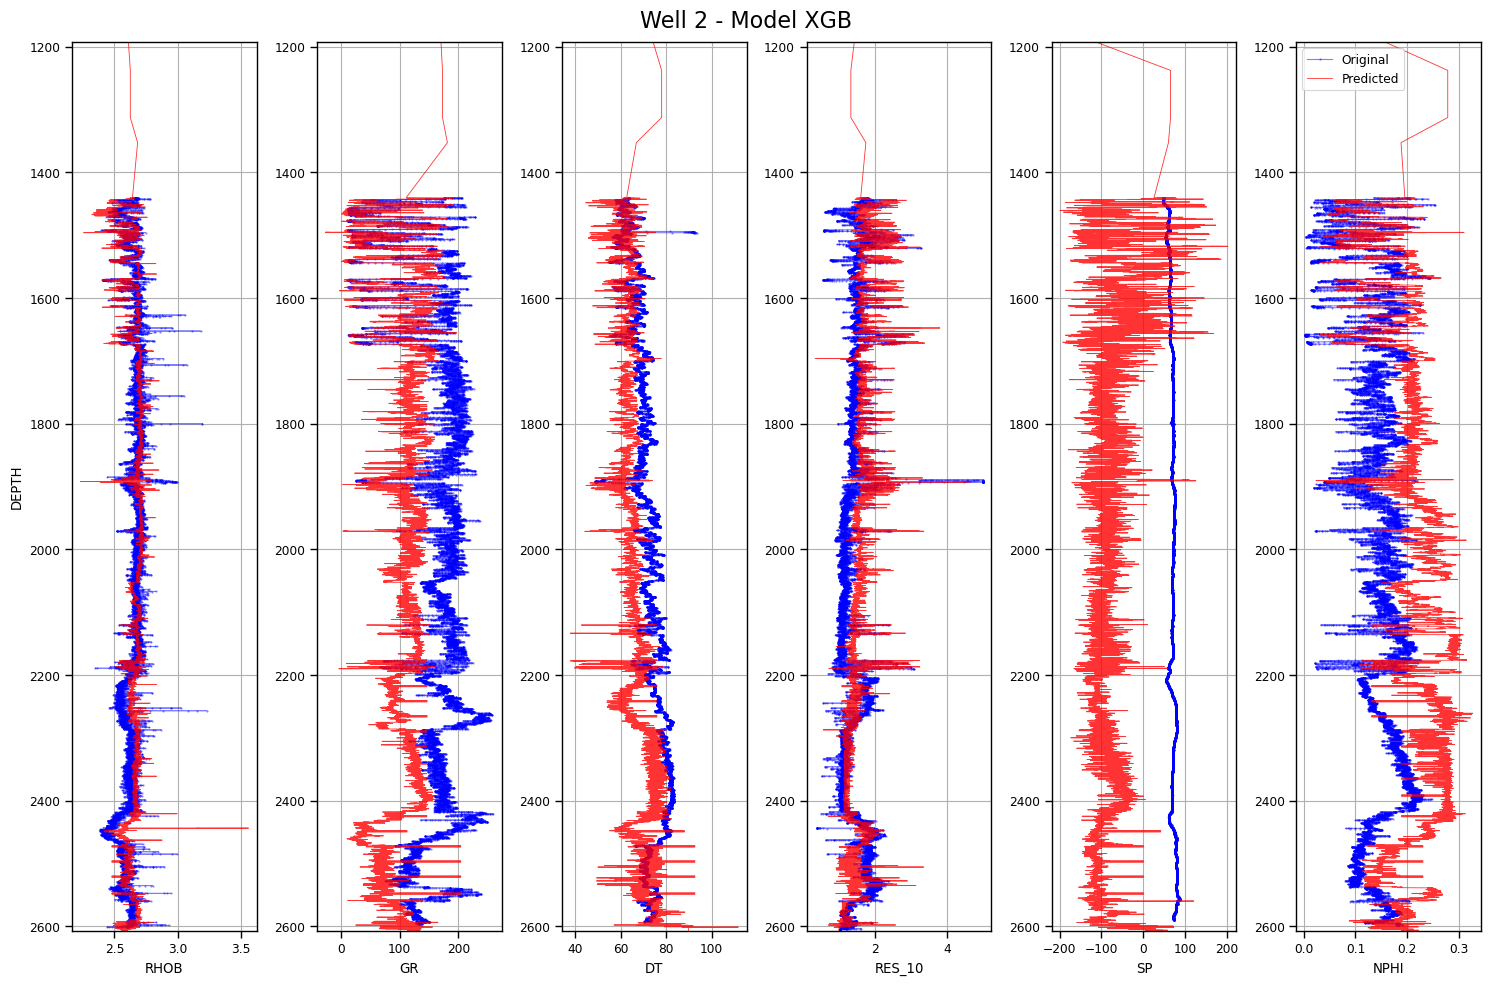

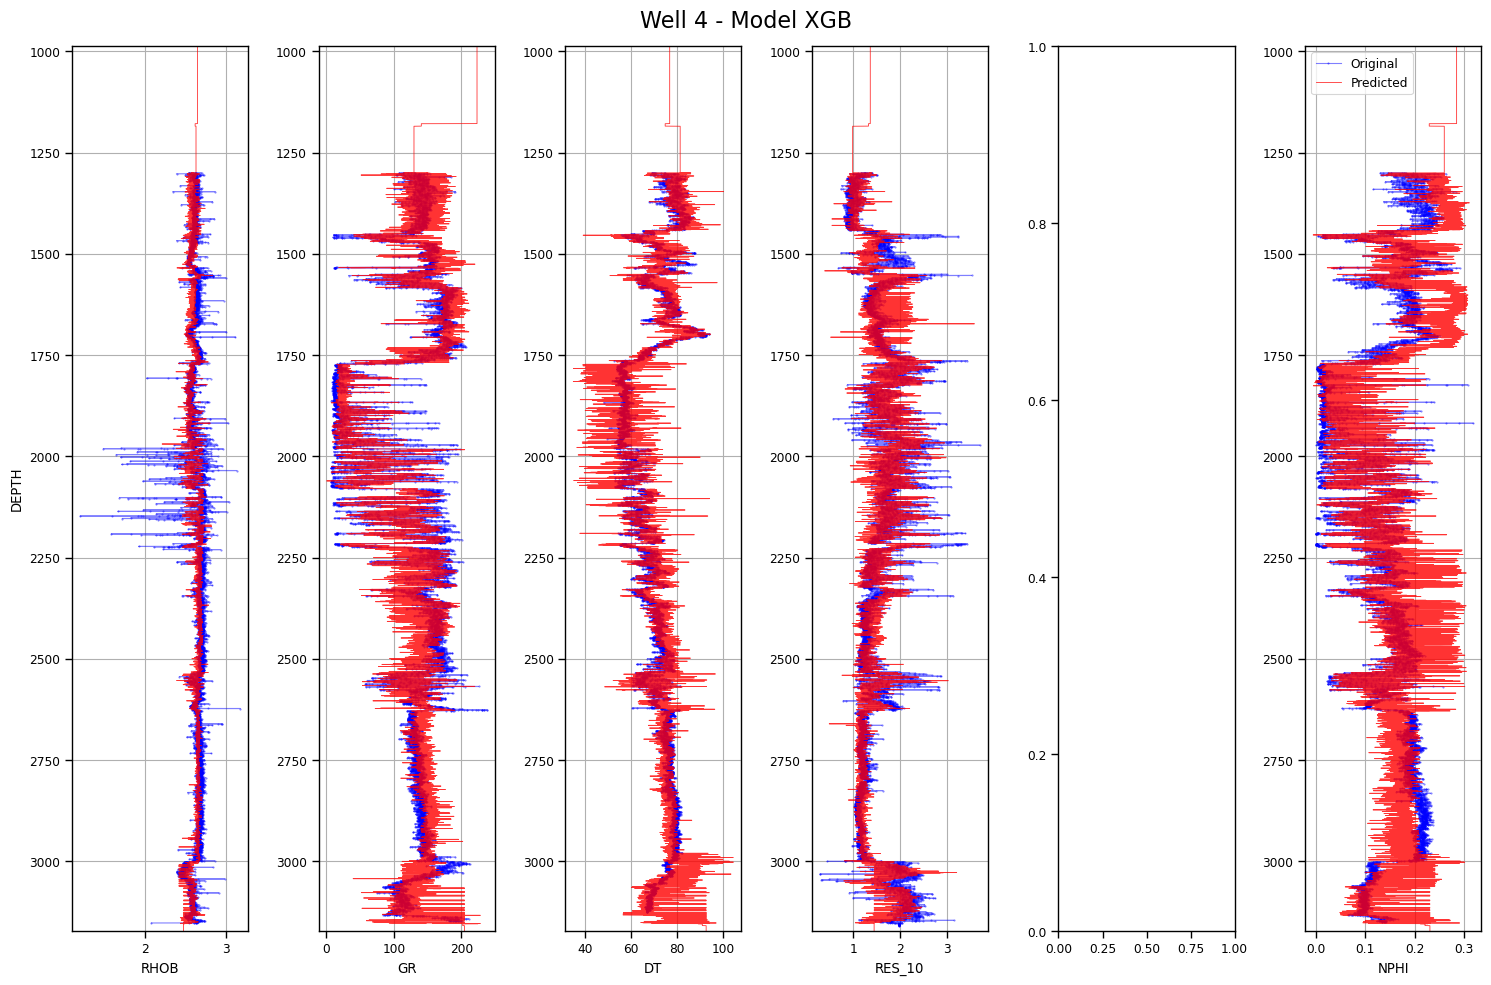

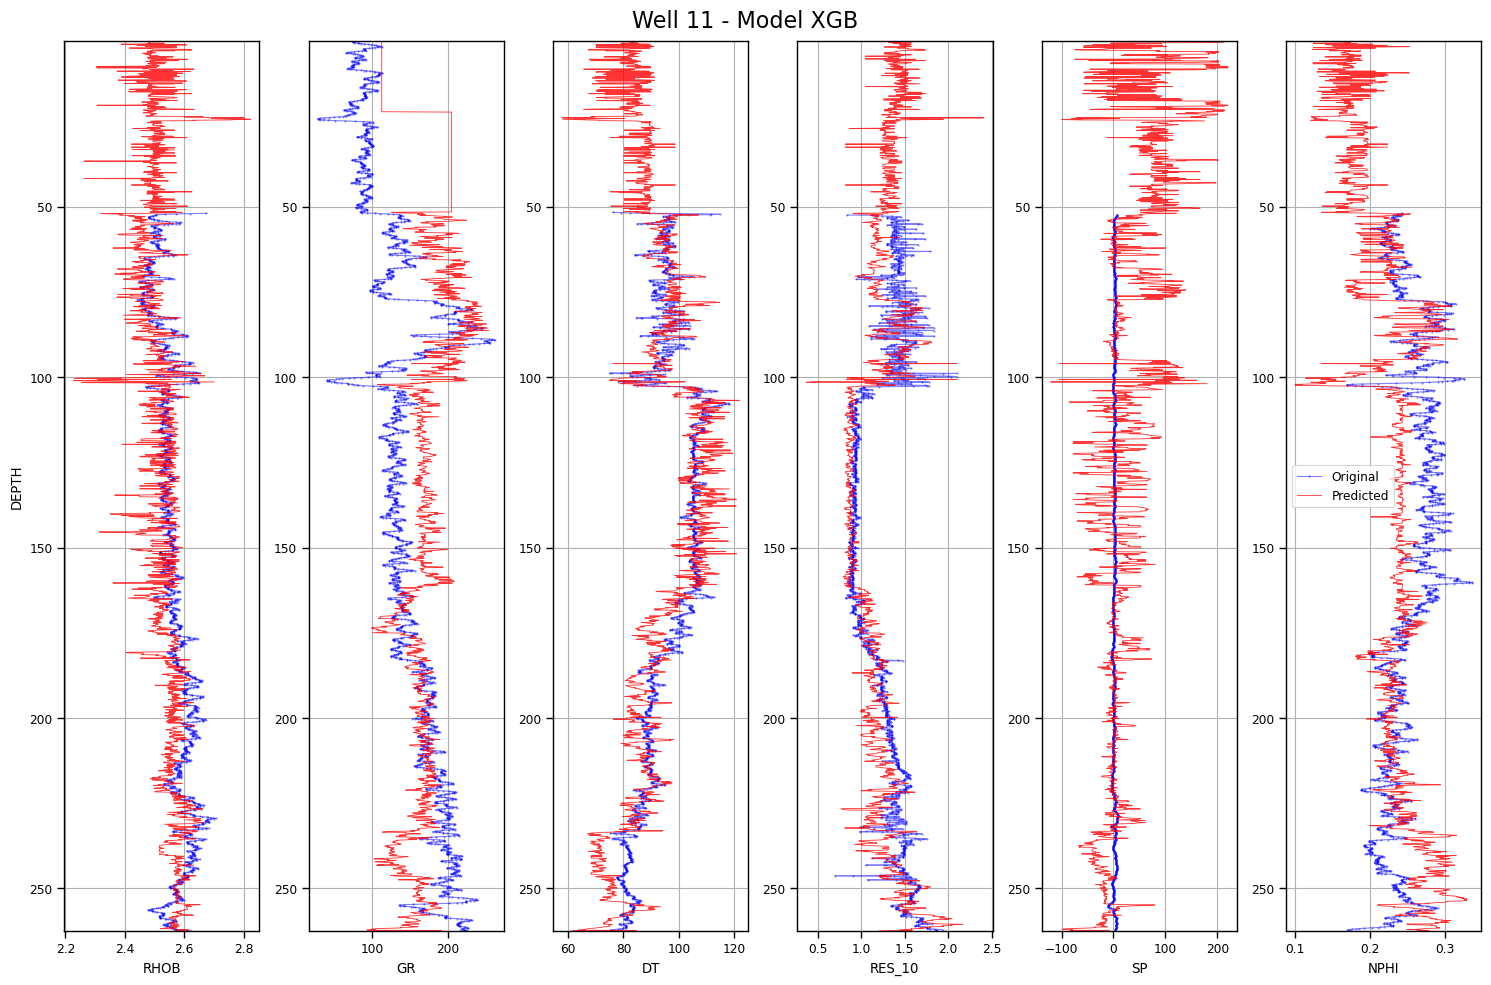

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


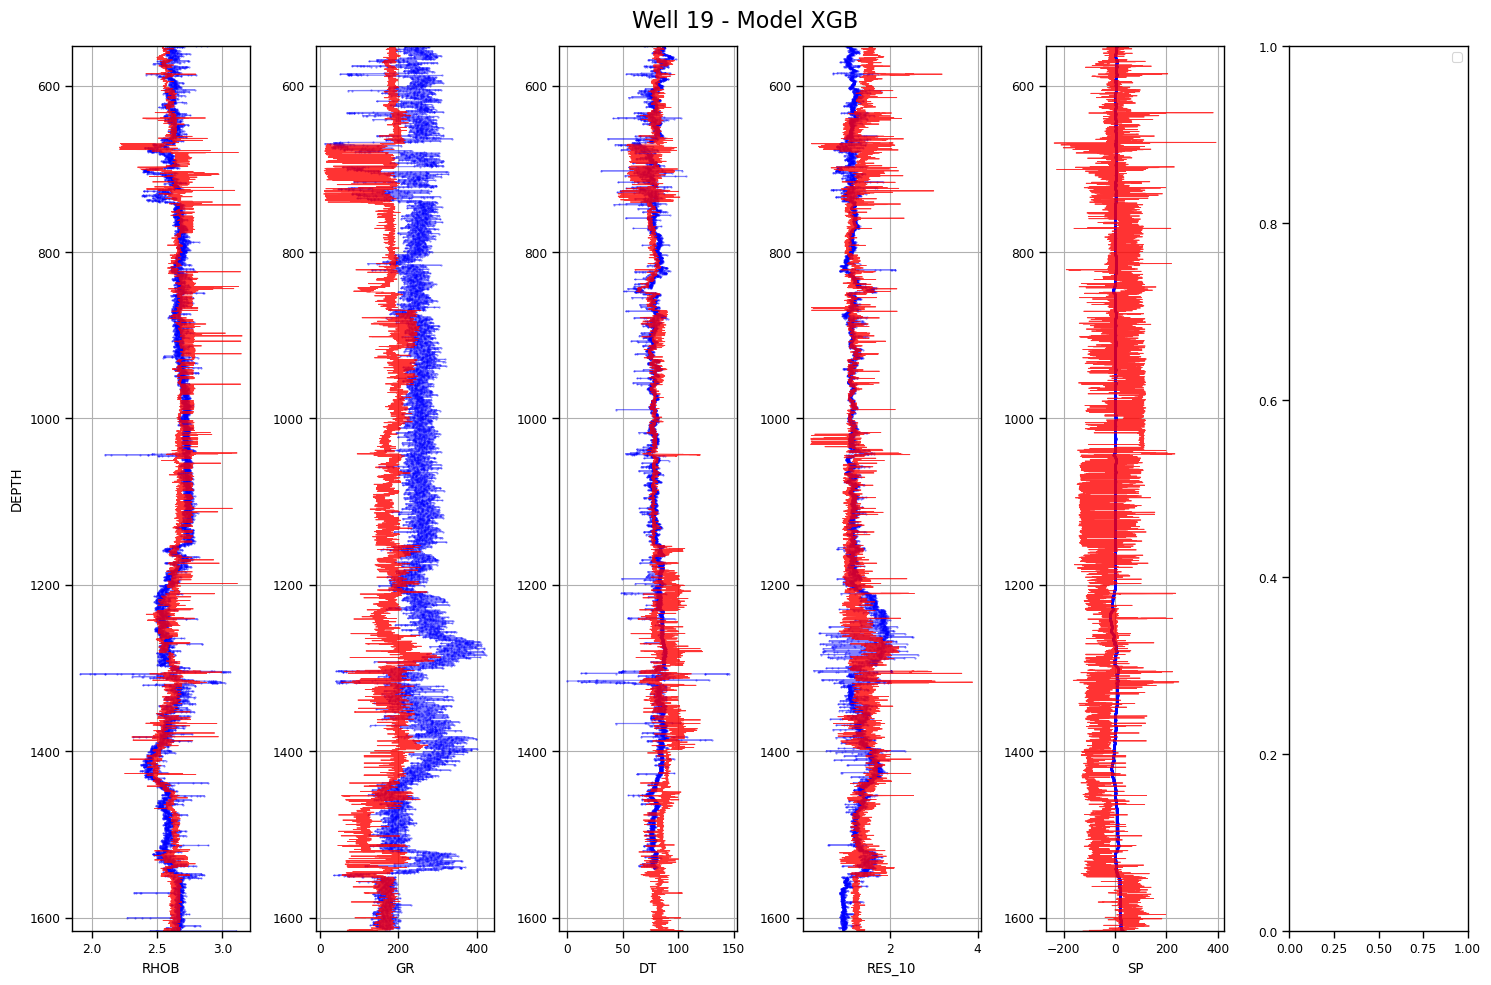

In [41]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
# model = 'BR'
models = ['XGB']

test_wells_plot = test_df['WELL'].unique()
# test_wells_plot = [2, 11, 28, 4]

for well in test_wells_plot:
    for model in models:
    
        results_wells(df=test_df, features=well_logs, name_well=well, model=model) 

In [31]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
# model = 'BR'
models = ['XGB']

# test_wells_plot = test_df['WELL'].unique()
test_wells_plot = [4, 19]

for well in test_wells_plot:
    for model in models:
    
        results_wells_scatter(df=test_df, features=well_logs, name_well=well, model=model) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [25]:
def results_wells_scatter(df, features, name_well, model): 
    
    well = df[df['WELL'] == name_well] 

    for idx, feature in enumerate(features):
        if well[feature].notnull().any():
            fig, ax = plt.subplots(figsize=(5, 5))
            scatter = sns.scatterplot(data=well, x=f'{feature}_IMP_{model}', y=f'{feature}', hue='LITHO', ax=ax)

            ax.set_xlabel(feature)
            scatter.legend_.remove()
            ax.set_xlabel(f'Imputed Values')
            ax.set_ylabel(f'Original Values')

            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            plt.title(f'Well {name_well} - {feature}')
            plt.tight_layout()
            plt.show()            
                    

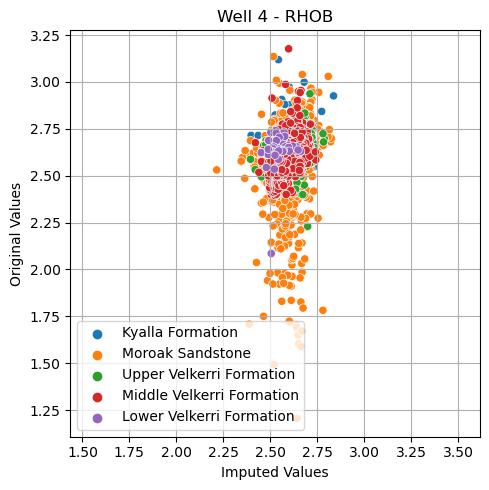

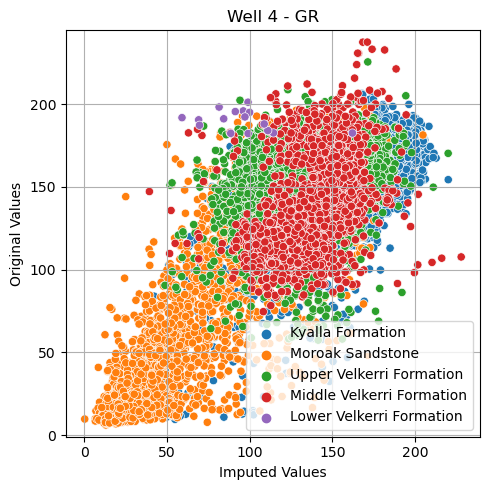

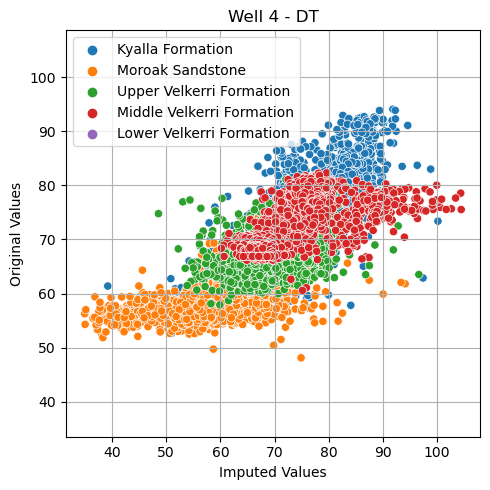

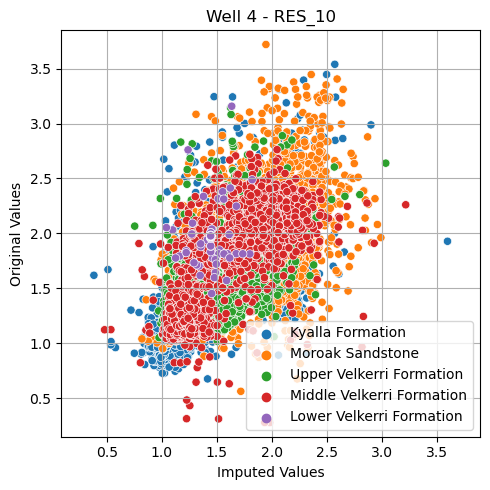

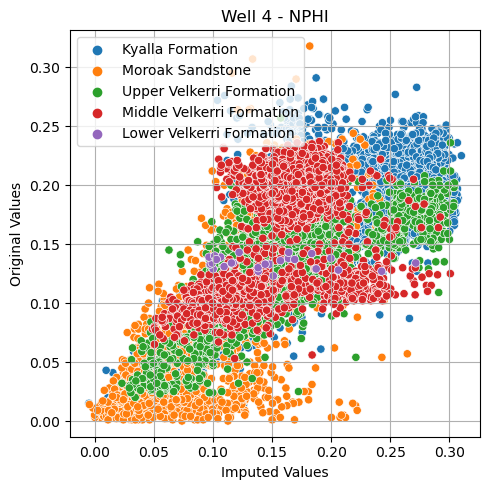

In [26]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']
# model = 'BR'
models = ['XGB']

# test_wells_plot = test_df['WELL'].unique()
test_wells_plot = [4]

for well in test_wells_plot:
    for model in models:
    
        results_wells_scatter(df=test_df, features=well_logs, name_well=well, model=model) 

### 3.5. Plotting Stratigraphy

In [46]:
def results_wells_strat(df, features, name_well, model, lito_strat):
    strat_df = df[df['STRAT'] == lito_strat] 
    
    
    well = strat_df[strat_df['WELL'] == name_well] 


    fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(15,10))

    for idx, feature in enumerate(features):
        if well[feature].notnull().any():
            ax[idx].plot(well[f'{feature}'], well['DEPTH'], marker='.', markersize=1, linewidth=0.8, alpha=0.5, color='blue', label='Original')
            ax[idx].plot(well[f'{feature}_IMP_{model}'], well['DEPTH'], linewidth=0.6, color='red', alpha=0.8, label='Predicted')
    #                 ax[idx].plot(well[f'{feature}_MICE'], well['DEPTH'], marker='o', linewidth=0.6, markersize=0.5, color='red', alpha=0.8, label='Predicted')
            ax[idx].set_ylim([min(well['DEPTH']), max(well['DEPTH'])])
            ax[idx].invert_yaxis()
            ax[idx].set_xlabel(feature)

            if idx == 0:
                ax[idx].set_ylabel('DEPTH')

            if feature == 'R10':
                ax[idx].set_xscale('log')

            ax[idx].grid(True) 
    ax[idx].legend()
    fig.suptitle(f'Well {name_well} - Model {model} - Litostratigraphy {lito_strat}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
def results_wells_strat_scatter(df, features, name_well, model, lito_strat):
    strat_df = df[df['STRAT'] == lito_strat] 
    
    
    well = strat_df[strat_df['WELL'] == name_well] 


    fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 4))

    for idx, feature in enumerate(features):
        if well[feature].notnull().any():
            sns.scatterplot(data=well, x=f'{feature}', y=f'{feature}_IMP_{model}', hue='LITHO', ax=ax[idx])

            ax[idx].grid(True) 
    ax[idx].legend()
    fig.suptitle(f'Well {name_well} - Model {model} - Litostratigraphy {lito_strat}', fontsize=16)
    plt.tight_layout()
    plt.show()
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


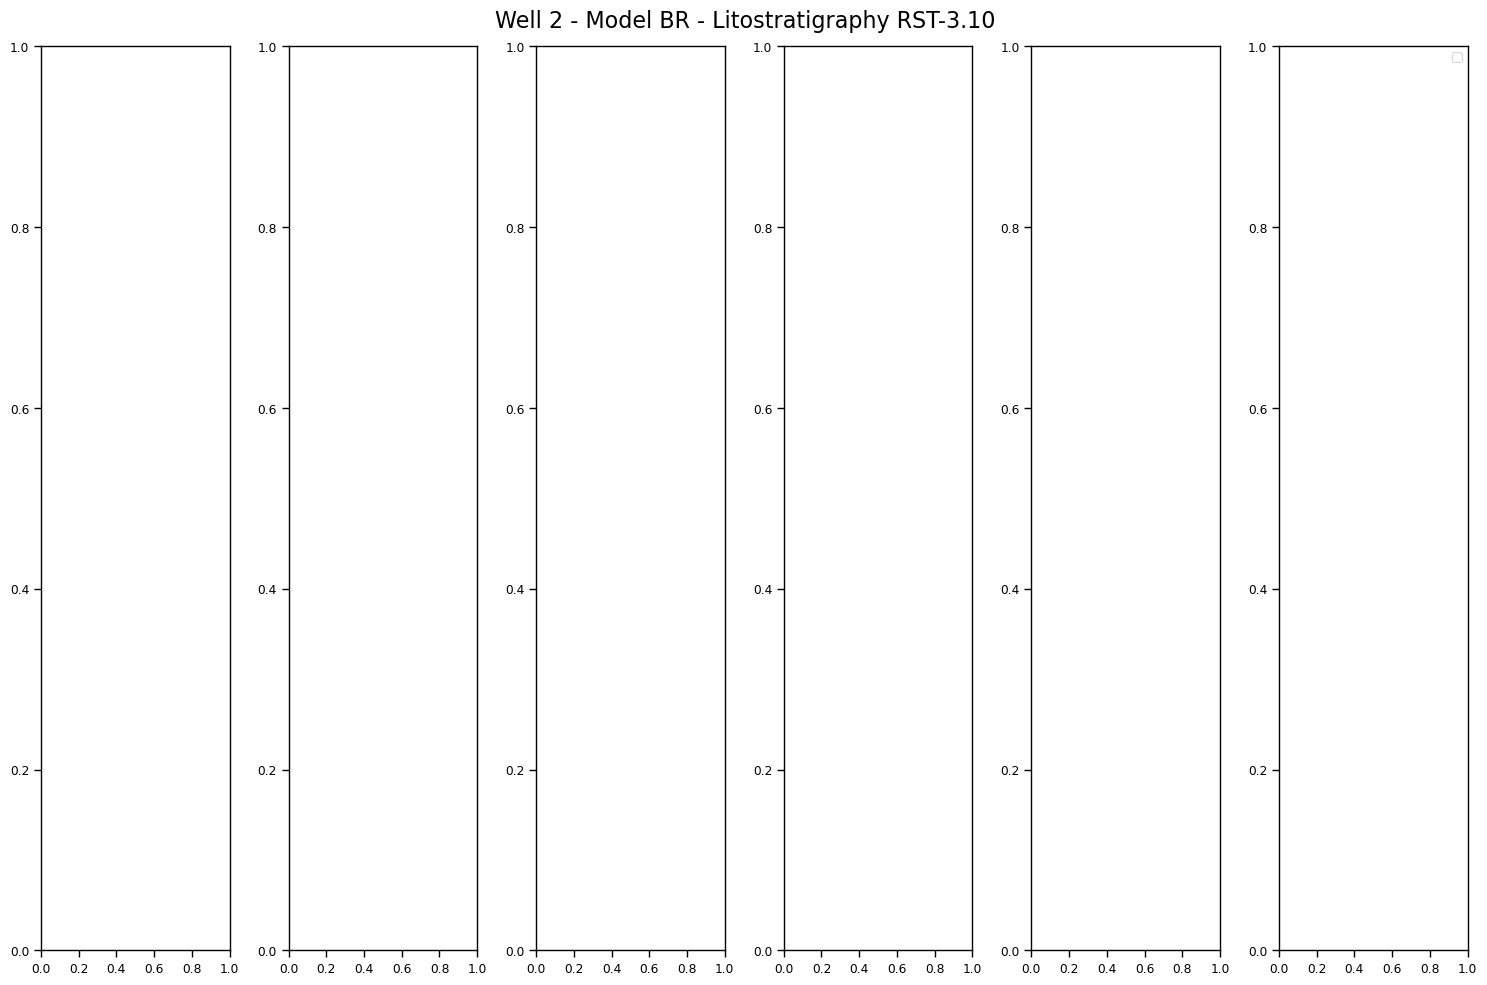

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


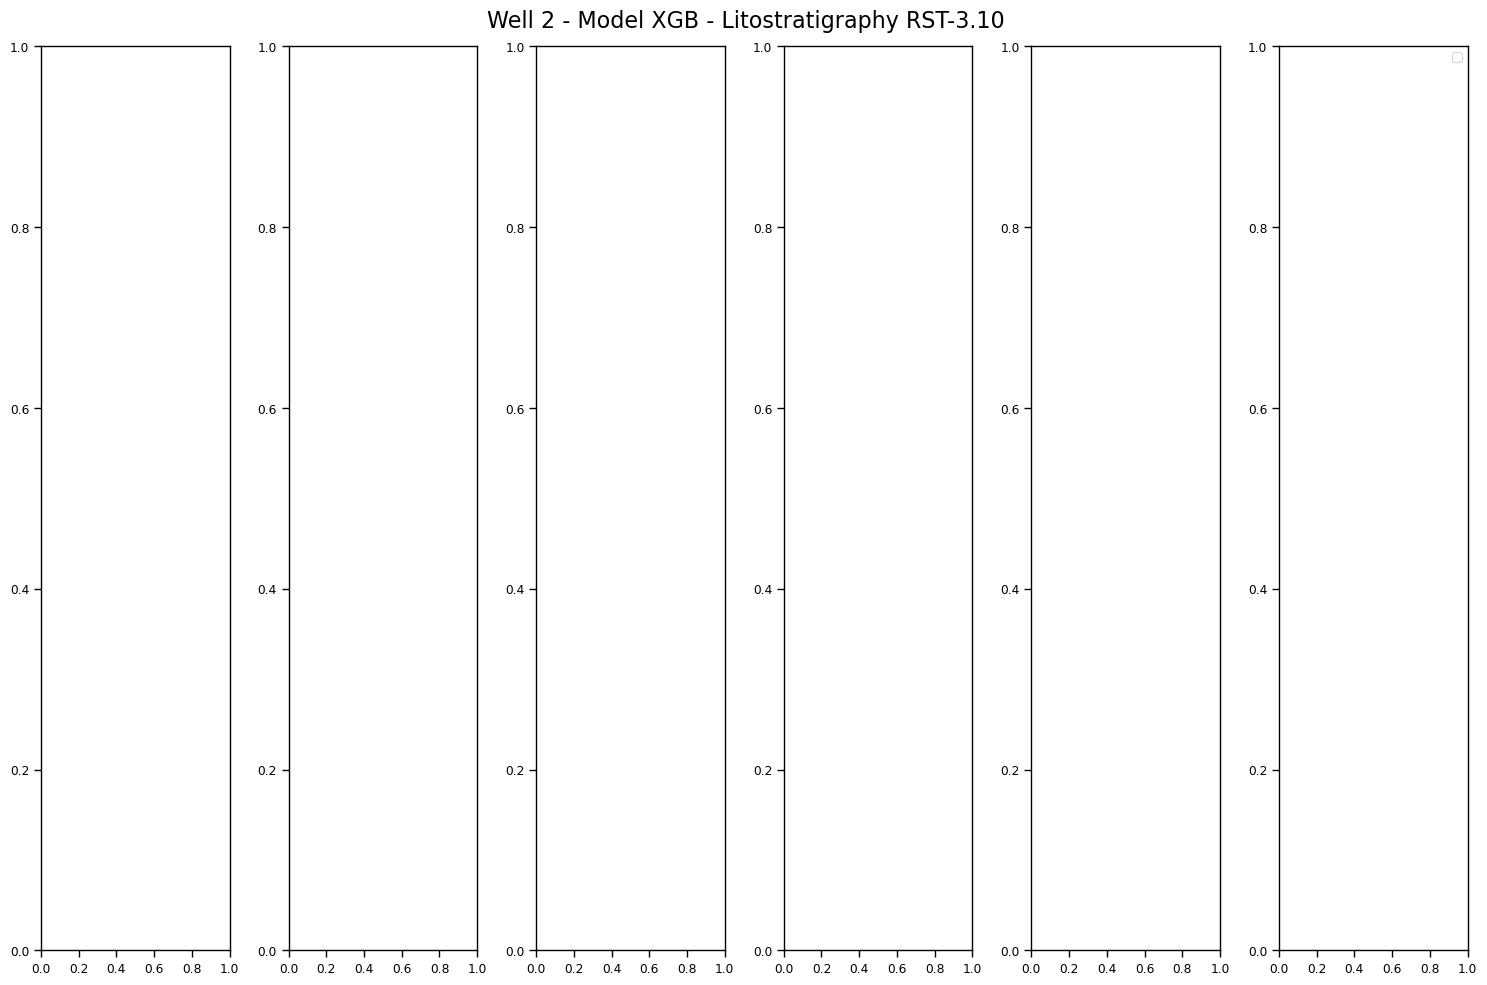

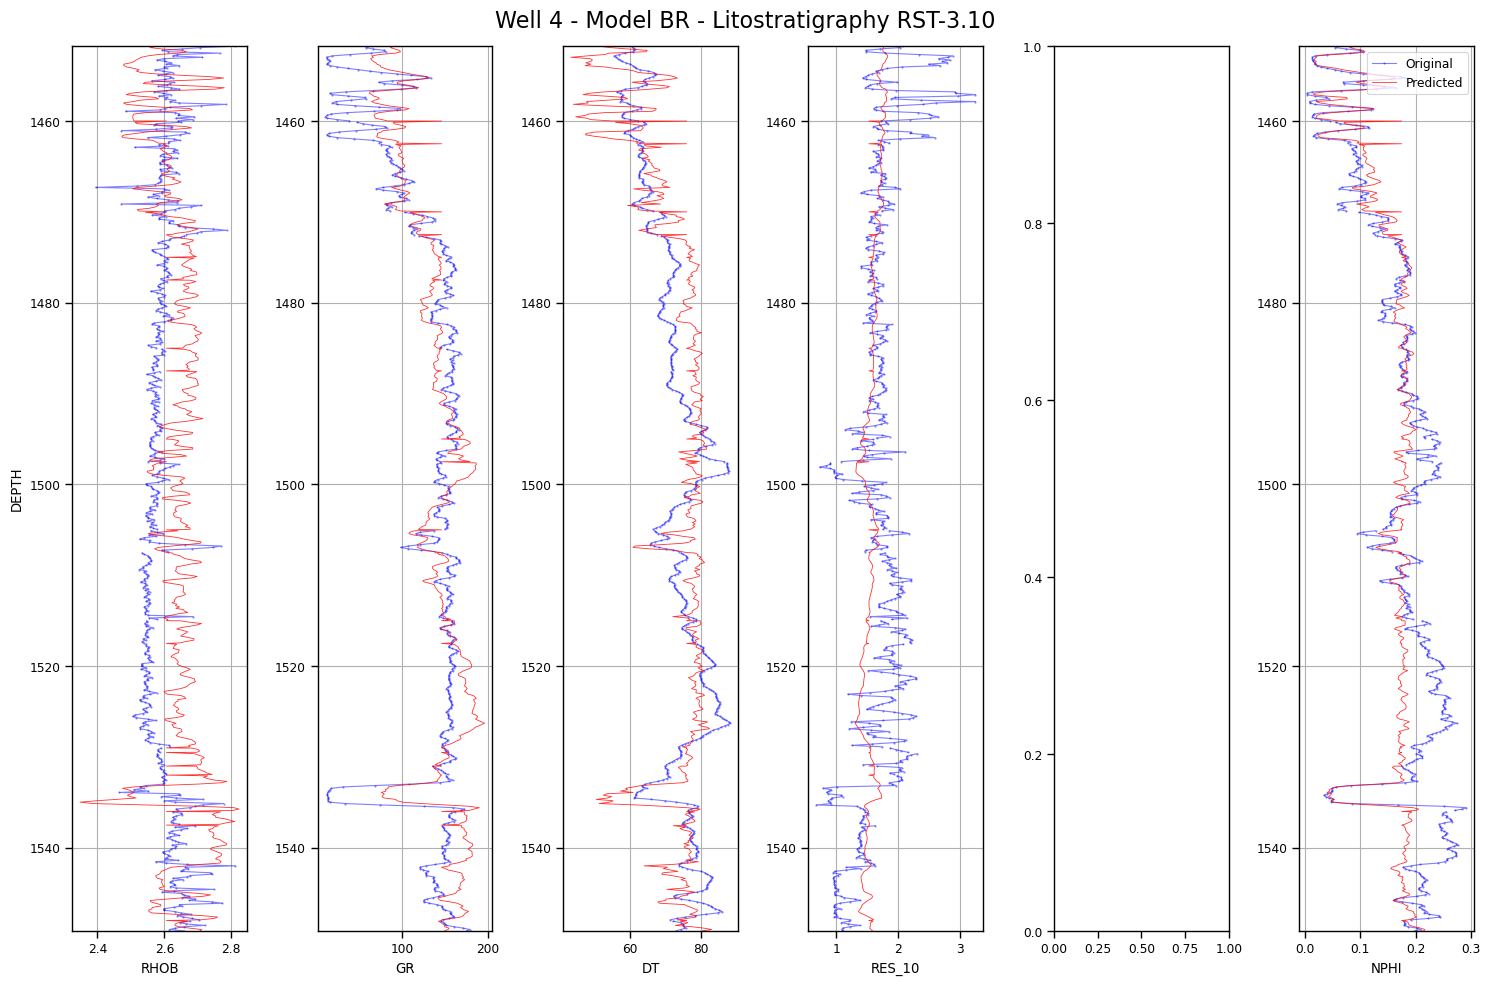

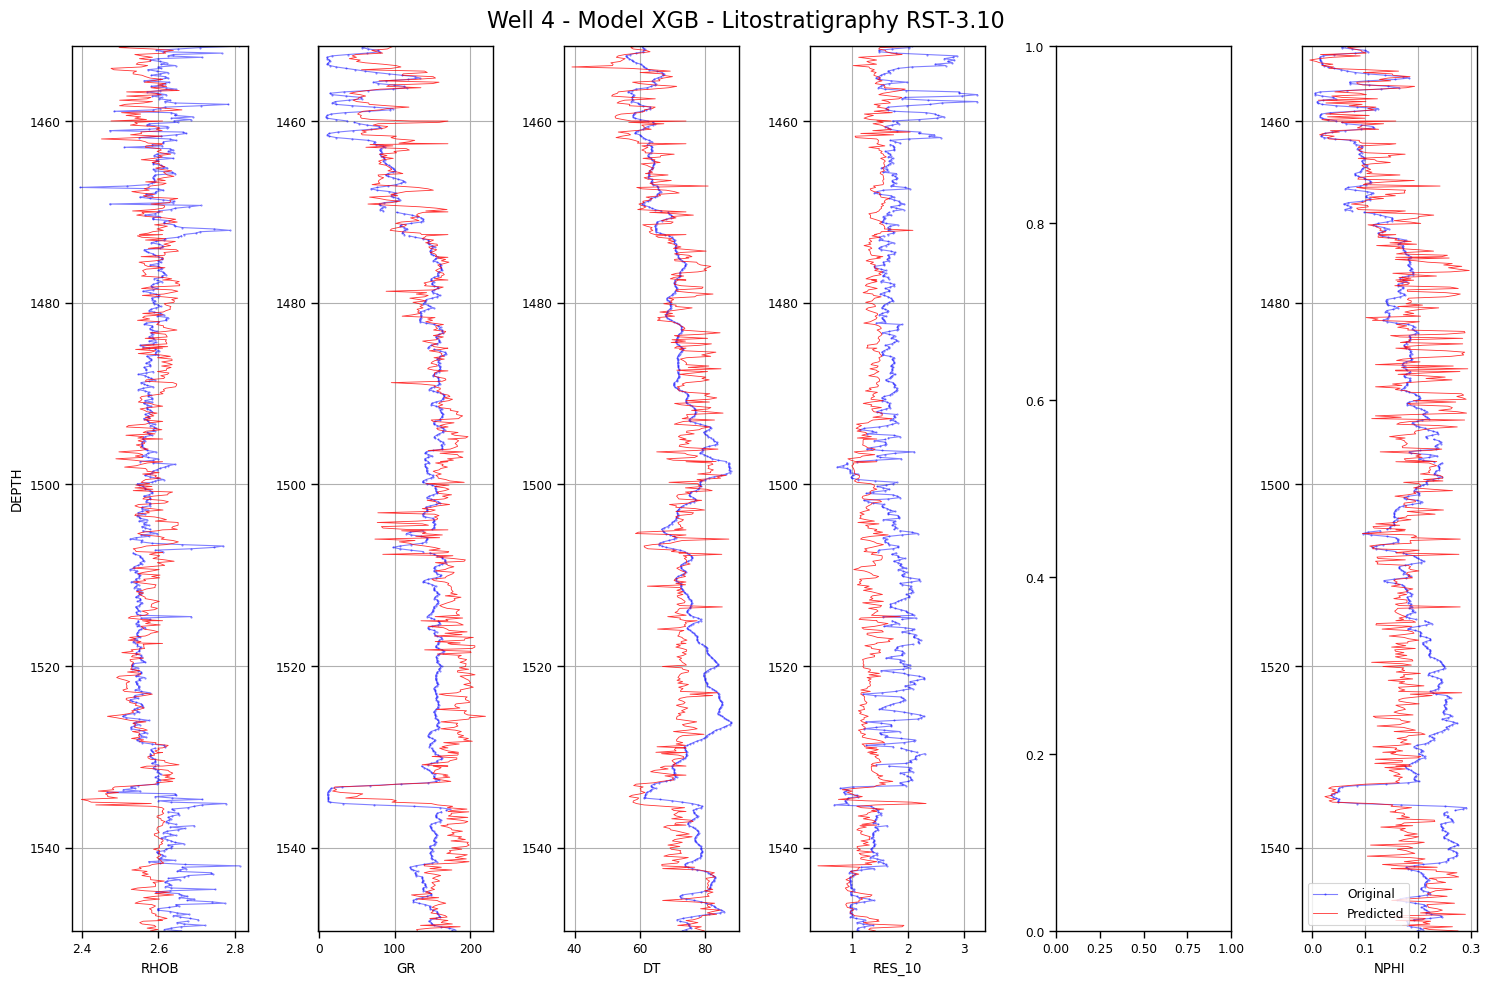

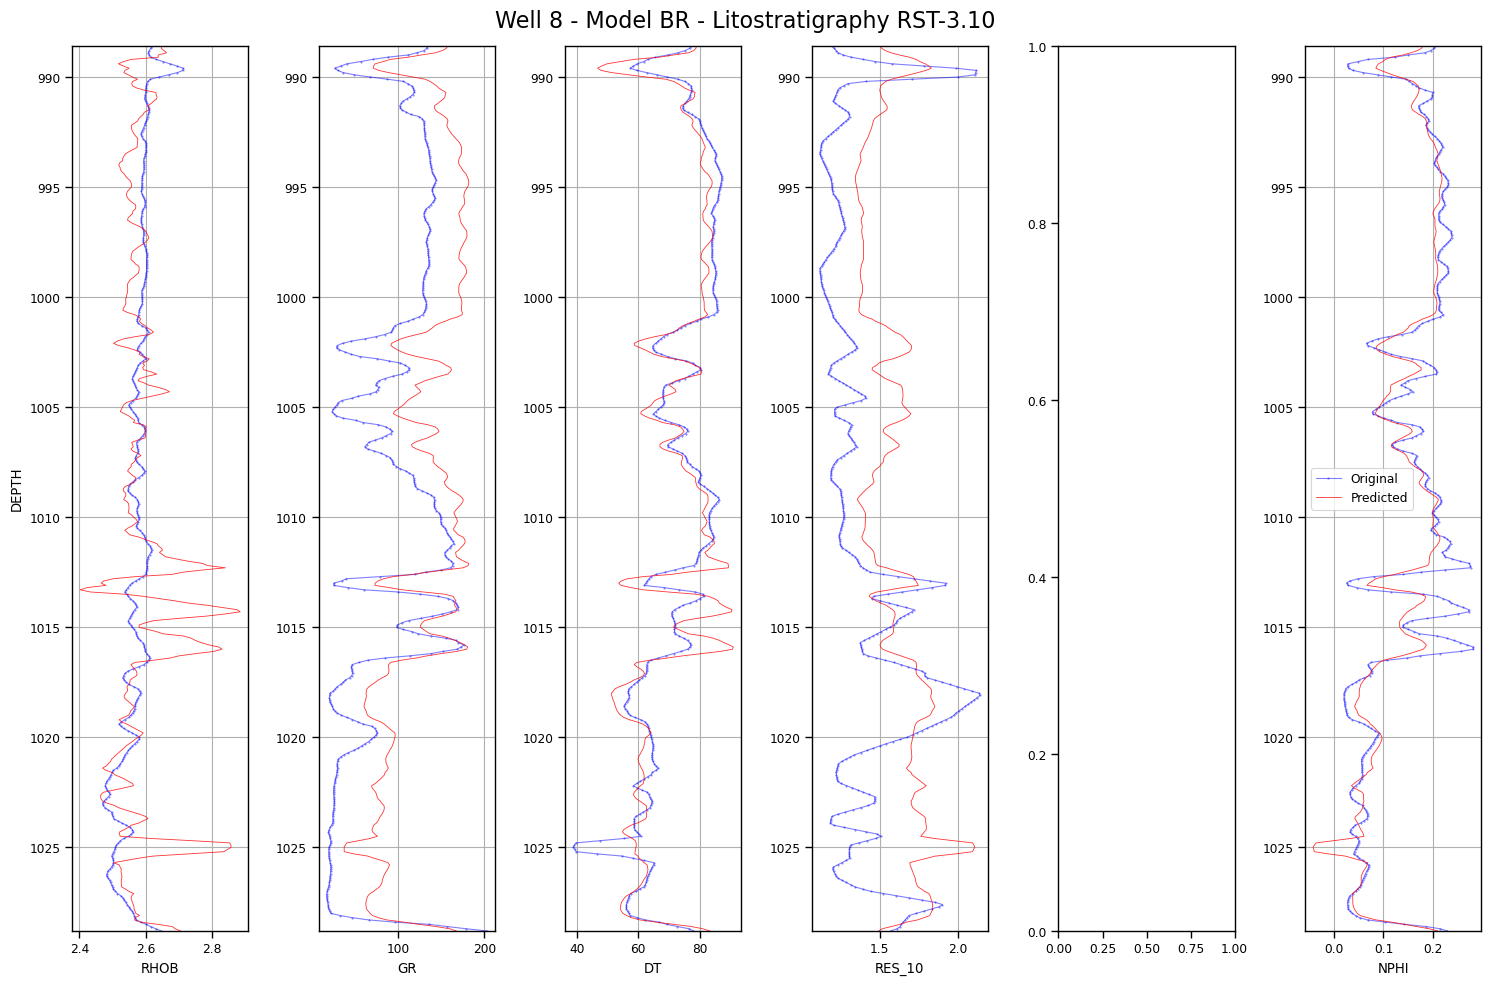

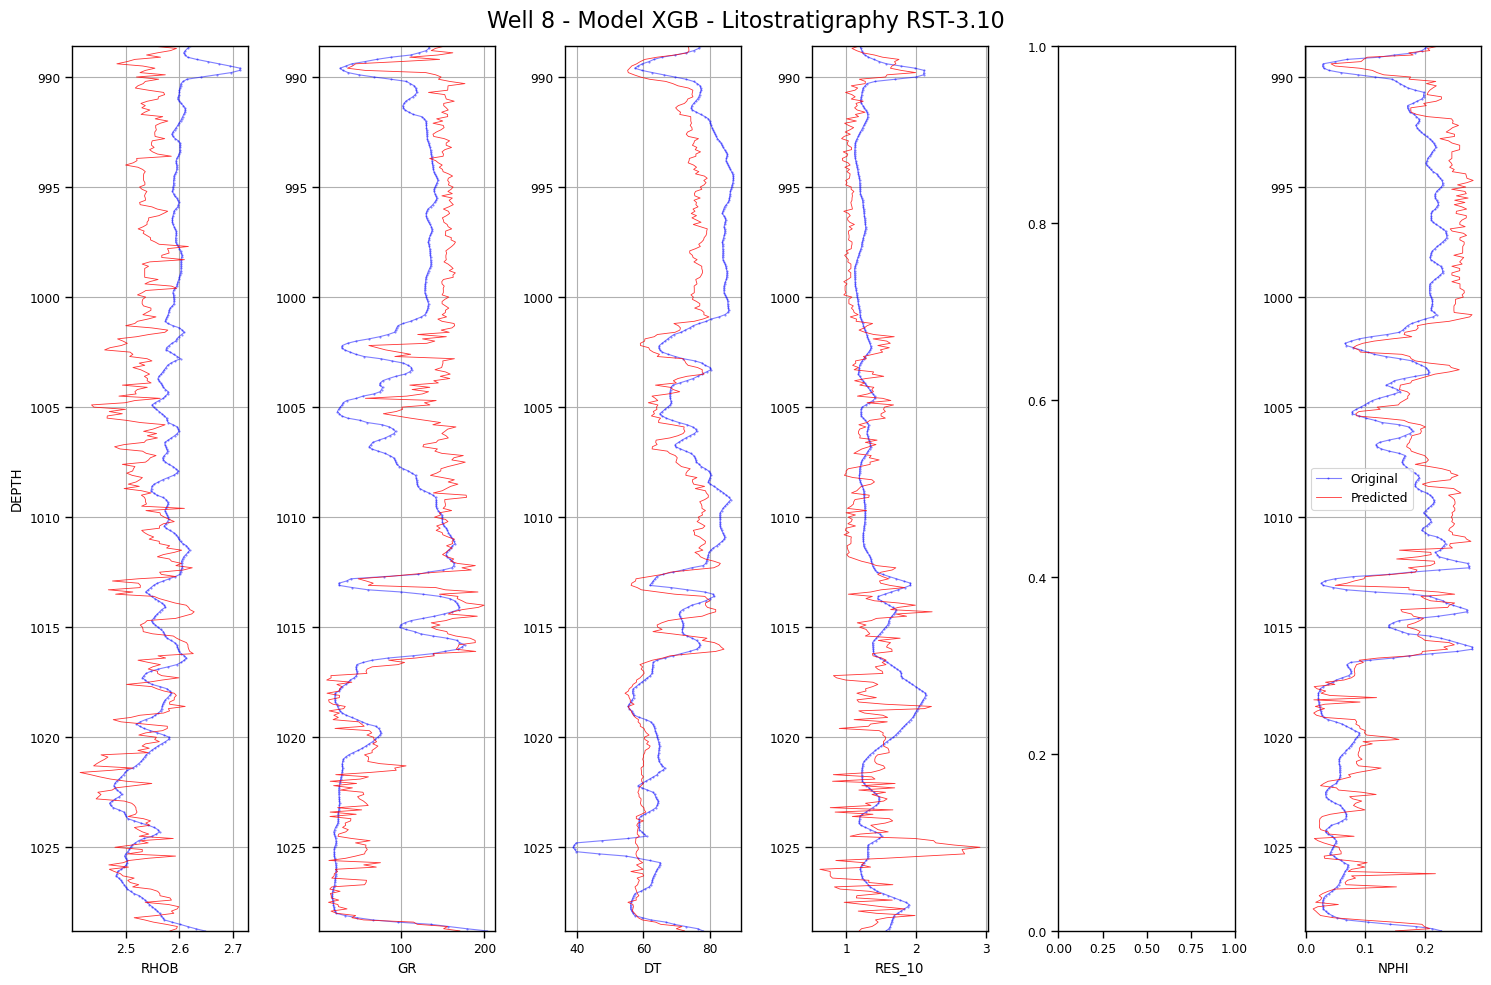

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


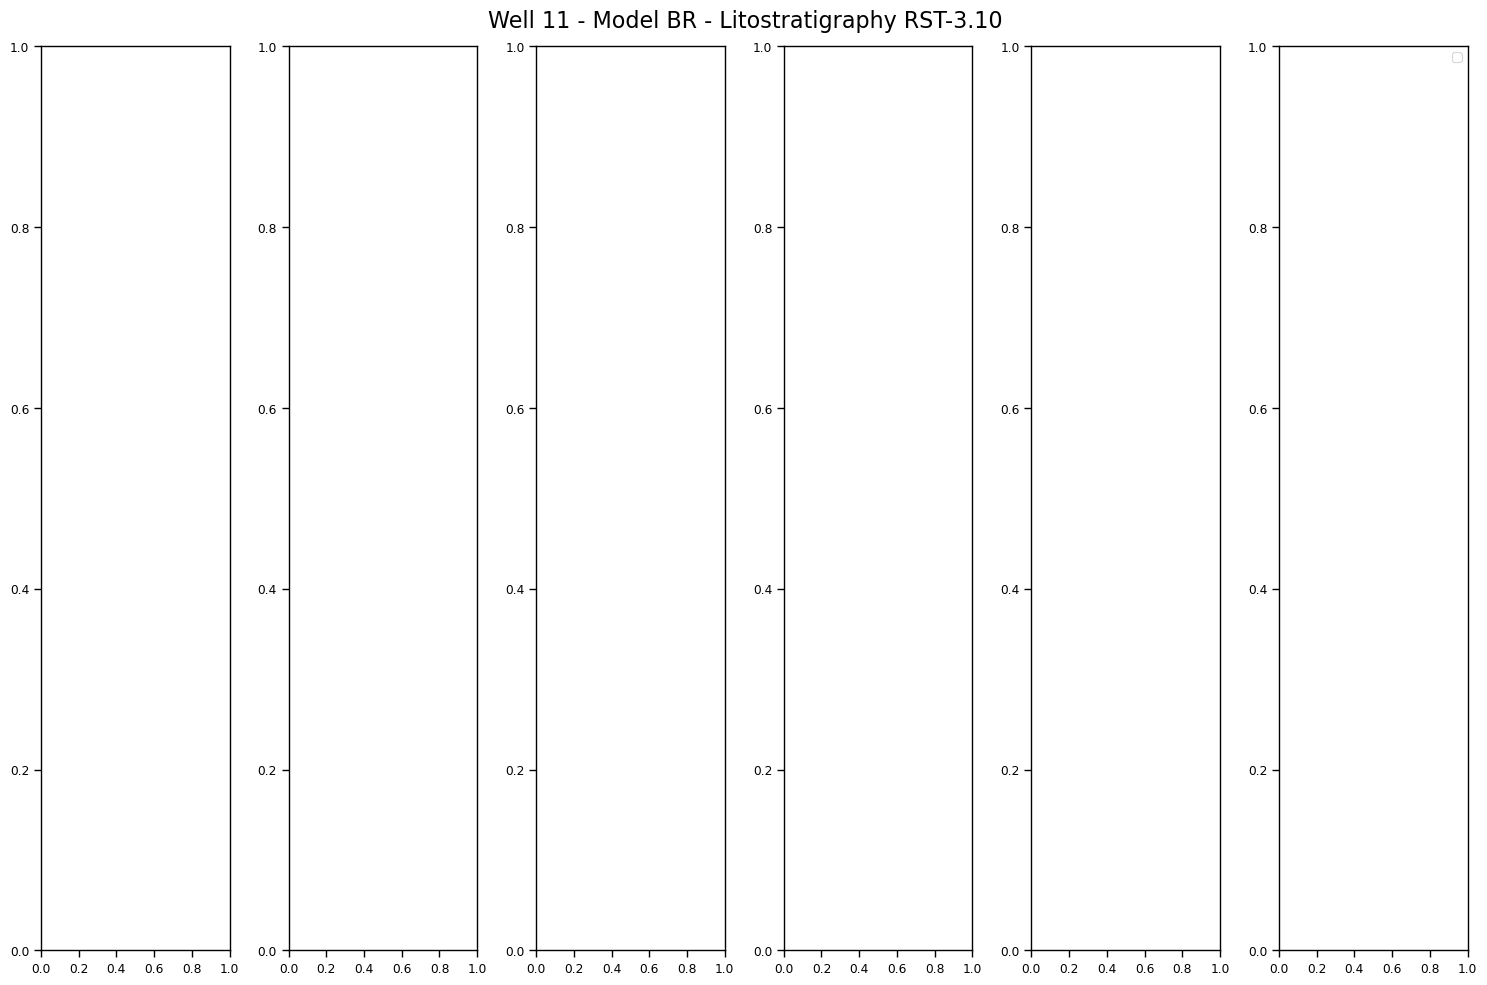

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


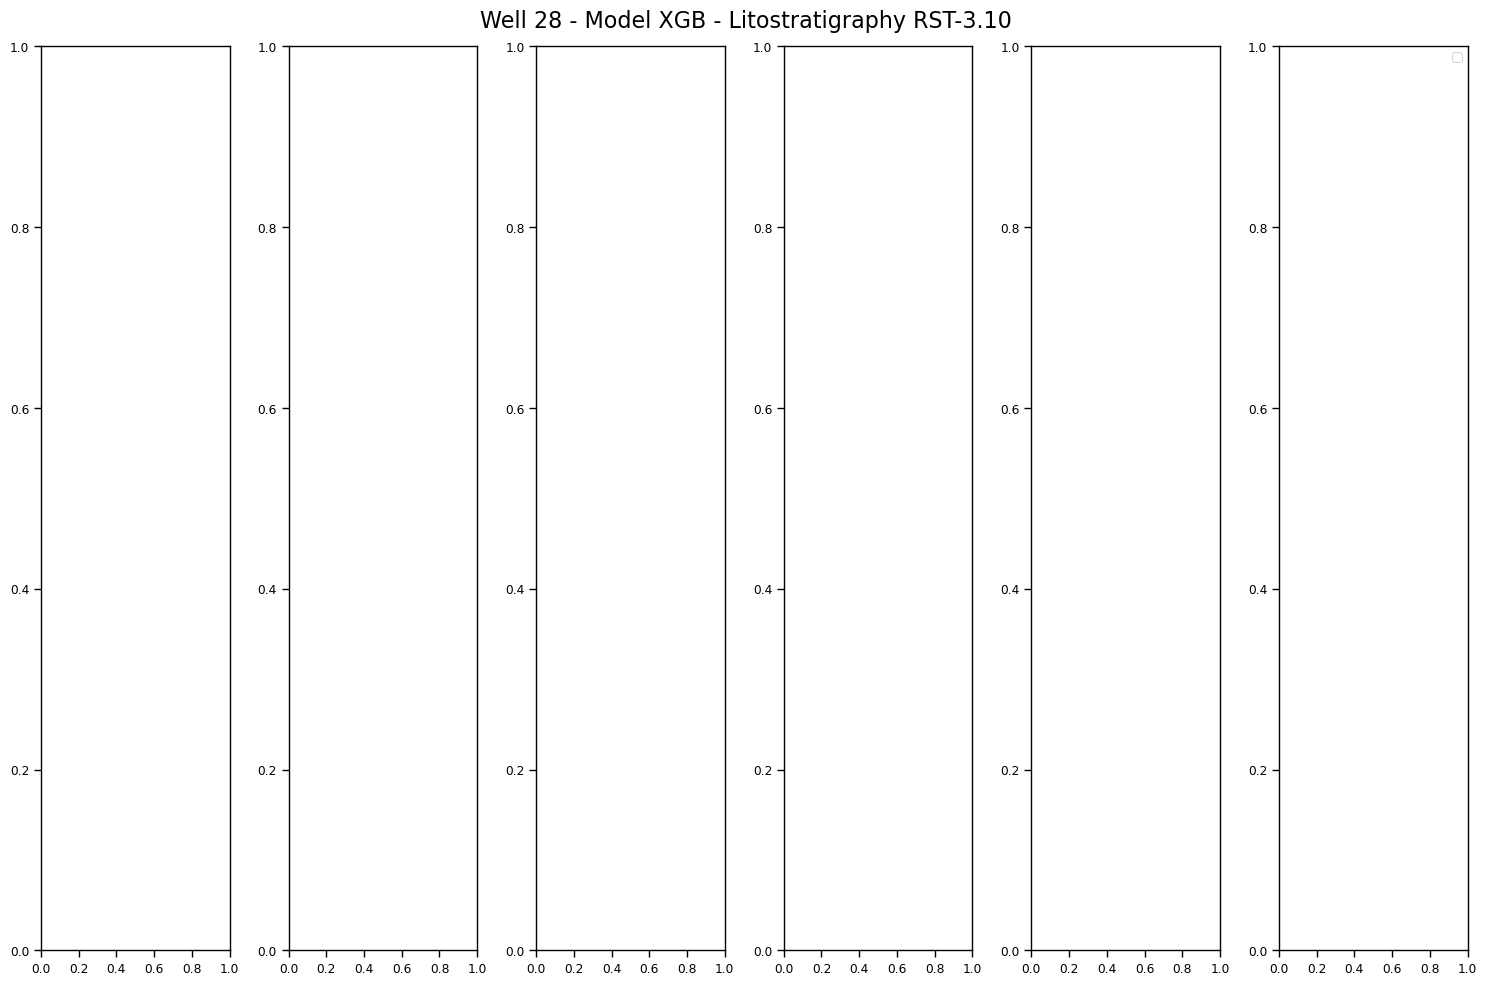

In [48]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

models = ['BR', 'XGB']

strats = ['RST-3.10']

test_wells_plot = test_df['WELL'].unique()


for well in test_wells_plot:
    for model in models:
        for strati in strats:
            results_wells_strat(df=test_df, features=well_logs, name_well=well, model=model, lito_strat=strati) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


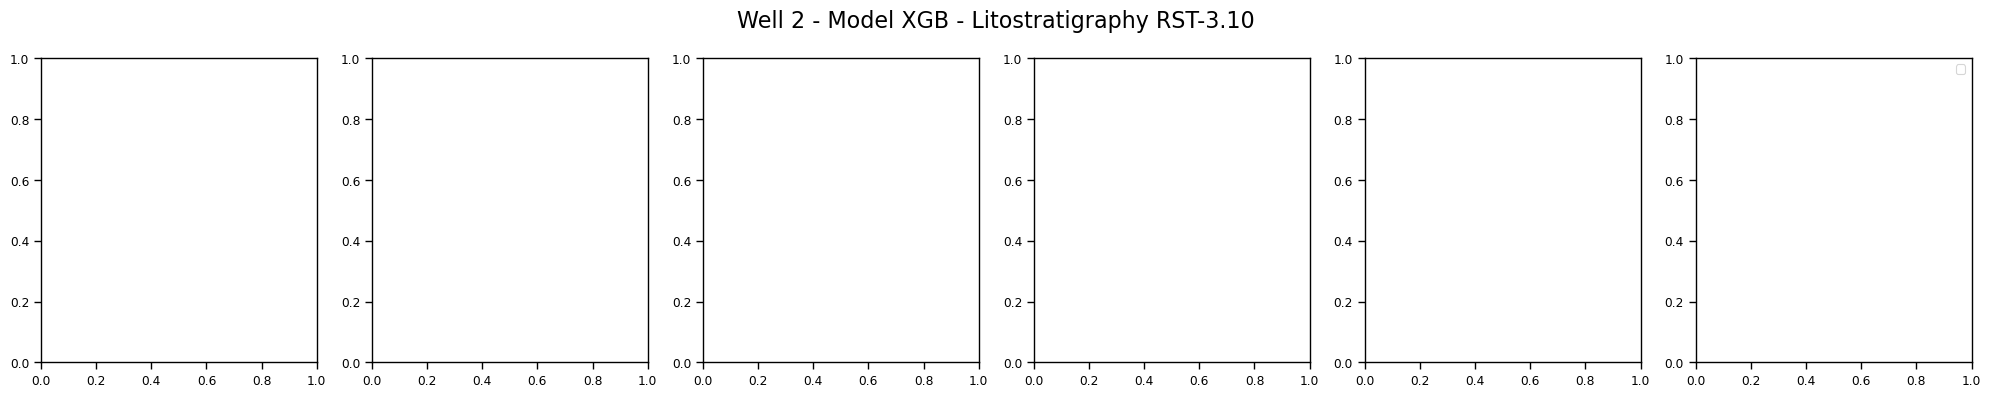

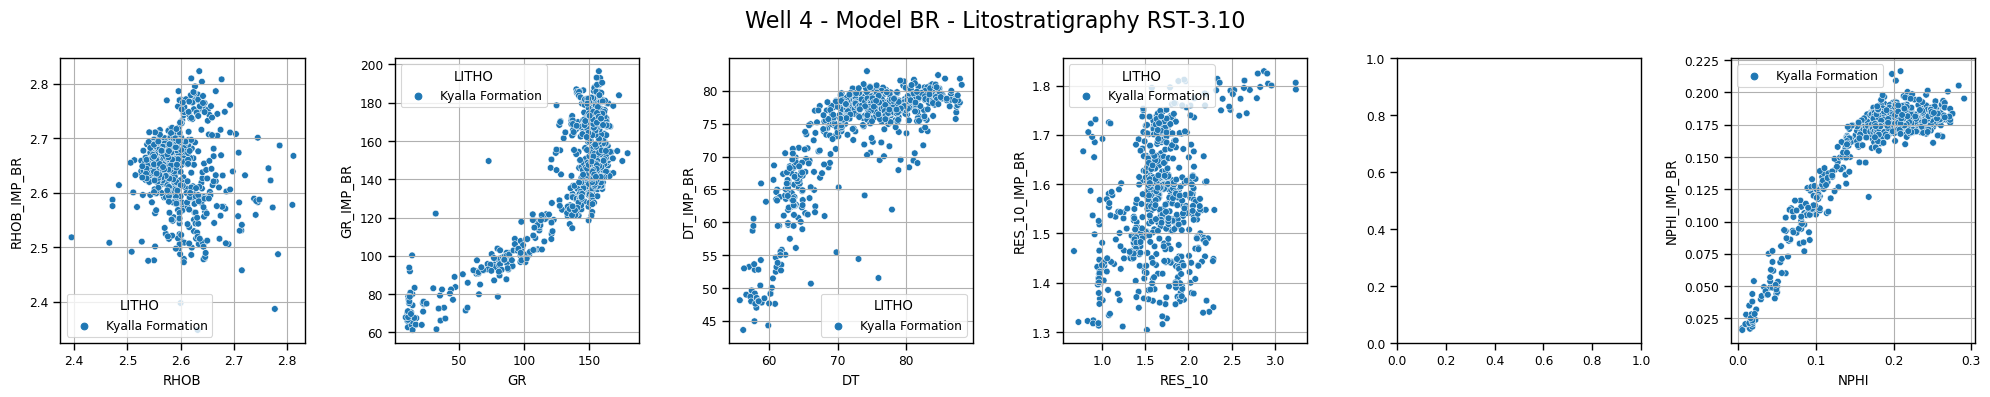

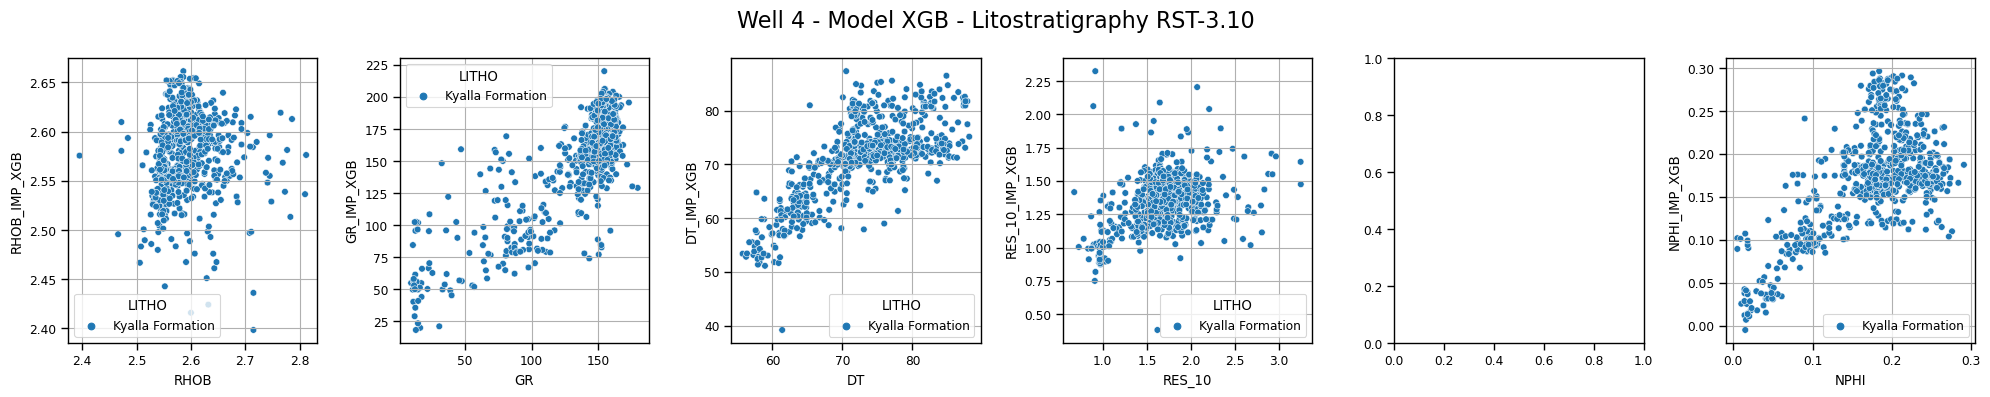

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


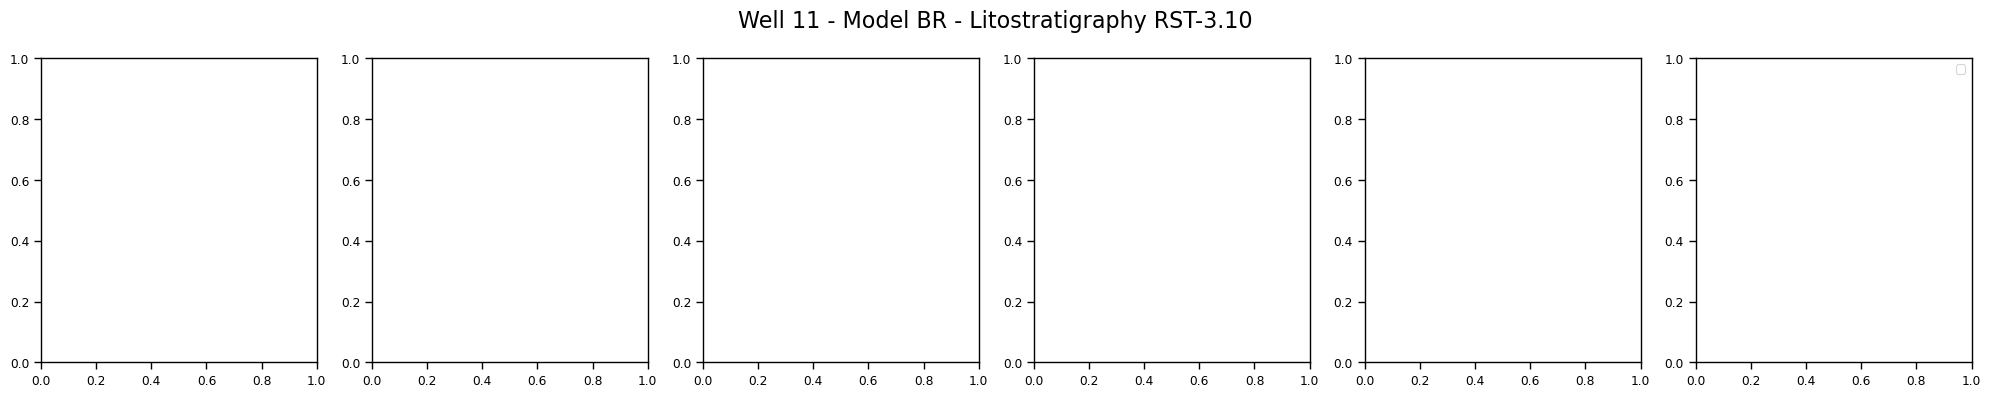

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


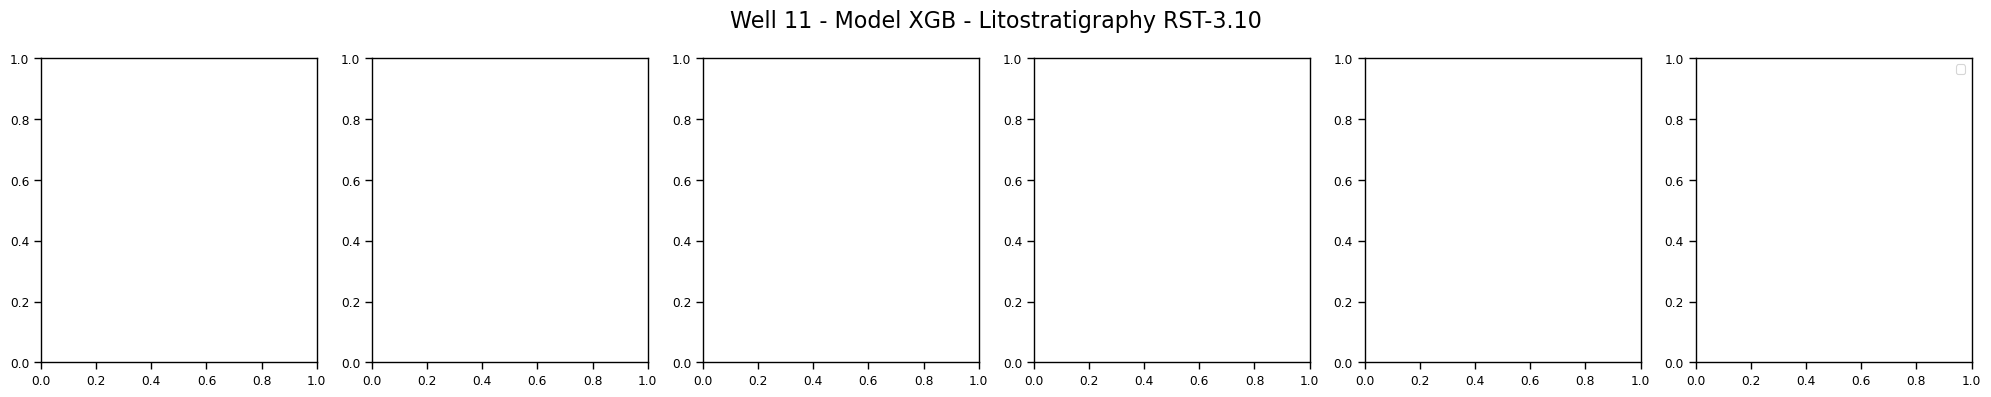

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


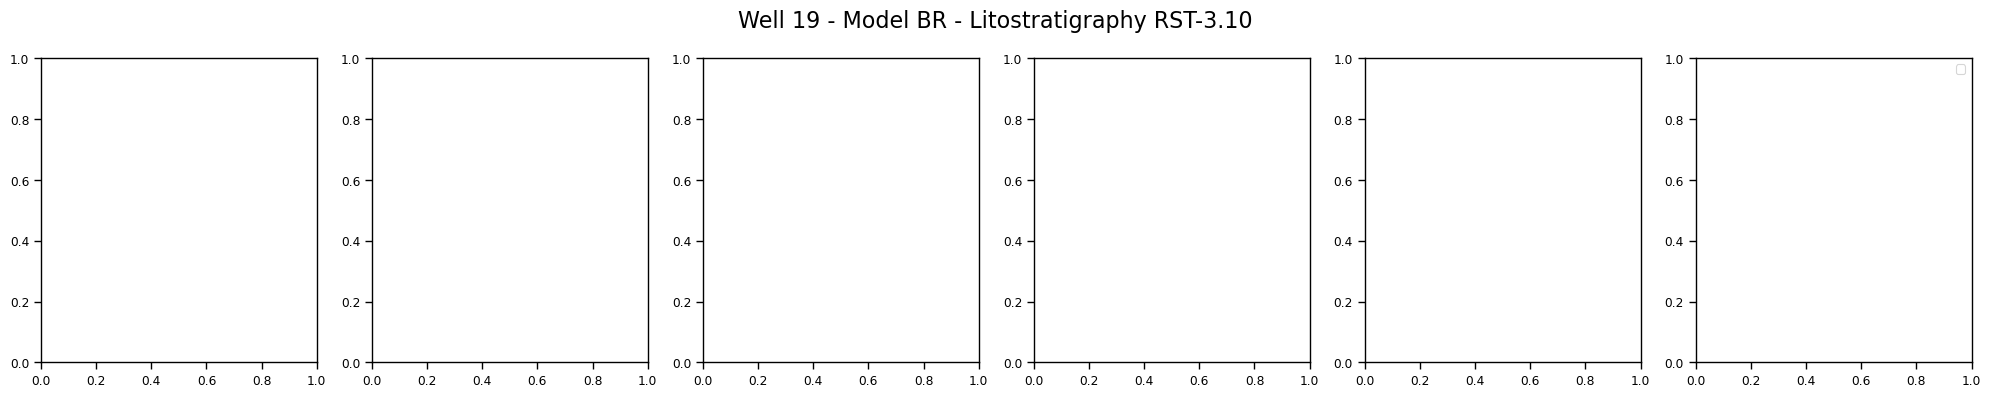

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


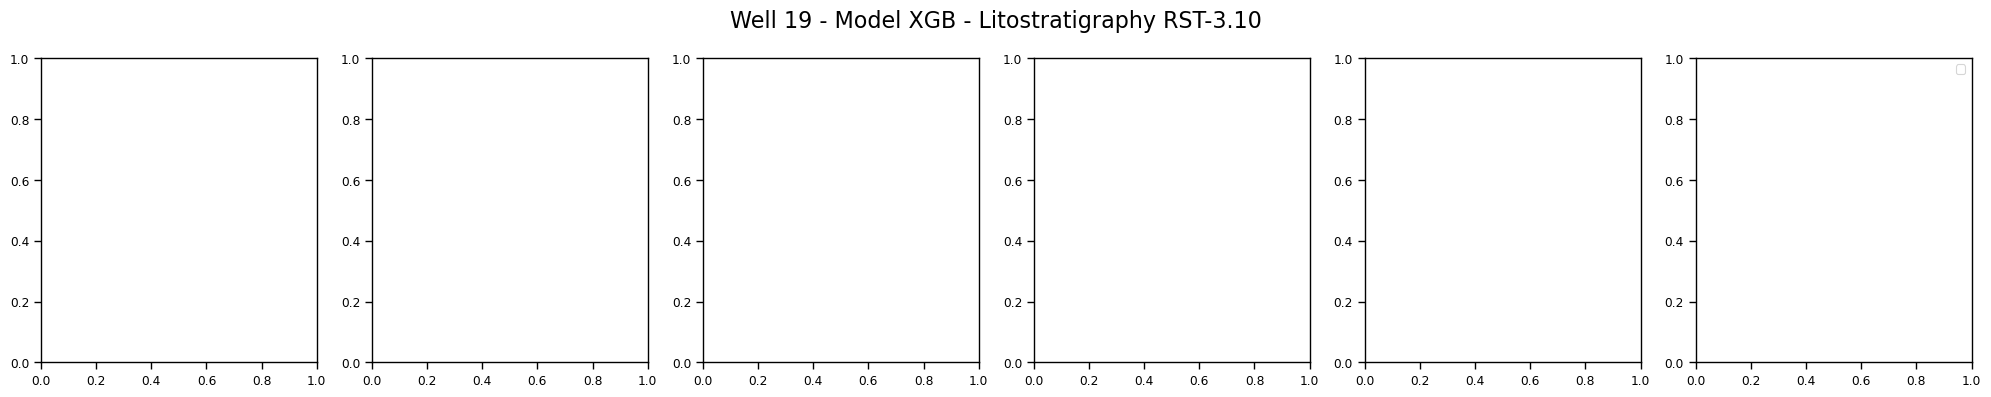

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


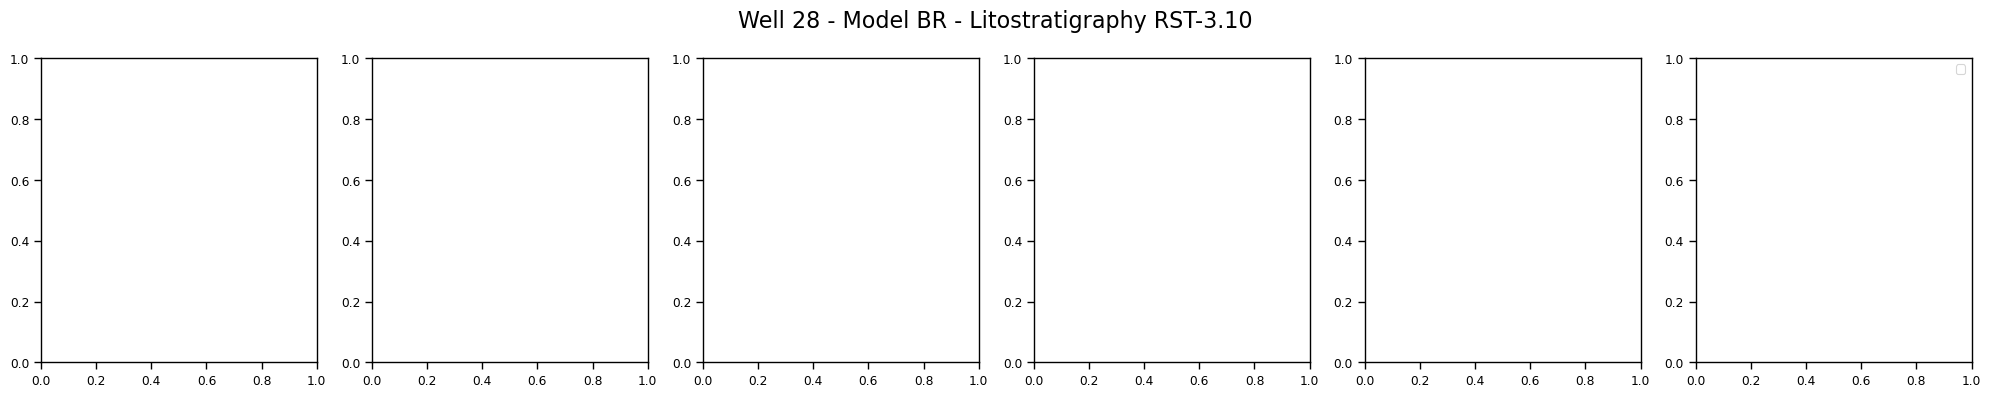

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [50]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

models = ['BR', 'XGB']

strats = ['RST-3.10']

test_wells_plot = test_df['WELL'].unique()


for well in test_wells_plot:
    for model in models:
        for strati in strats:
            results_wells_strat_scatter(df=test_df, features=well_logs, name_well=well, model=model, lito_strat=strati) 